In [1]:
#Import necessary libraries
import pandas as pd
import os
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from sklearn.compose import make_column_selector as selector
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
import keras

pd.options.display.max_columns = None
pd.options.display.max_rows = None
SEED=42


In [2]:
TARGET_COLUMN = 'default_cus12'

In [3]:
def print_score(true, pred, pred_proba=None, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    else:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
    
    if pred_proba is not None:
        # ROC and AUC
        fpr, tpr, _ = roc_curve(true, pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        
        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(true, pred_proba)
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, color='b', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve')
        
        plt.tight_layout()
        plt.show()
        
        # Average decision score
        average_decision_score = np.mean(pred_proba)
        print(f"Average Decision Score: {average_decision_score:.2f}")




# Data Loading

In [197]:
ABT_DATA_PATH = os.path.join('/Users','ewelinakowalewska','Desktop','credit_scoring')
train_data='abt_sam_beh_train.csv'
valid_data='abt_sam_beh_valid.csv'

def load_train(data_path=ABT_DATA_PATH,typ=train_data):
    return pd.read_csv(os.path.join(data_path, typ), sep=';',na_values=['M','I'])

def load_valid():
    return load_train(typ=valid_data)

In [198]:
train_df, valid_df = load_train(), load_valid()
valid_df['is_validation'] = True
train_df['is_validation'] = False

In [199]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50565 entries, 0 to 50564
Columns: 2311 entries, cid to is_validation
dtypes: bool(1), float64(1726), int64(579), object(5)
memory usage: 891.2+ MB


In [200]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50420 entries, 0 to 50419
Columns: 2311 entries, cid to is_validation
dtypes: bool(1), float64(1726), int64(579), object(5)
memory usage: 888.6+ MB


In [201]:
def reduce_storage(df):
    for n, t in zip(df.dtypes.index, df.dtypes):
        if t == 'int64':
            if df[n].min() >= 0:
                df[n] = pd.to_numeric(df[n], downcast = 'unsigned')
            else:
                df[n] = pd.to_numeric(df[n], downcast = 'signed')
        elif t == 'float64':
            df[n] = pd.to_numeric(df[n], downcast = 'float')
        else:
            pass
    return df

In [202]:
valid_df = reduce_storage(valid_df)
train_df = reduce_storage(train_df)
df = pd.concat([valid_df, train_df])

In [203]:
df.shape

(100985, 2311)

# Target Manipulation

Target codes

- 1 - customer during next 12 months went into more than 3 due installmens, 
- 0 - had only 1 due installment, 
- .i - other cases, 
- . - luck of next 12 months history

In [204]:
# we need to have those observations with the target data
def get_train_data(df, target_column):
    missing_indicator = 'I'
    filtered_df = df[~df[target_column].fillna(missing_indicator).isin([missing_indicator])].copy()
    _removed_rows_no = df.shape[0] - filtered_df.shape[0]
    print(f"Removed {_removed_rows_no} rows ({round(_removed_rows_no/df.shape[0]*100, 1)}% of original data)")
    y = filtered_df[target_column].astype(int)
    X = filtered_df.drop(columns=target_column)
    return X, y
    
X, y = get_train_data(df=df, target_column=TARGET_COLUMN)

Removed 12100 rows (12.0% of original data)


# Data Cleaning

## checking duplicates

In [205]:
# Duplicate checking for 'cid' and 'period' column combinations
duplicates = X.duplicated(subset=['cid', 'period'], keep=False)

# Check if there are any duplicates
if duplicates.any():
    print("There are duplicates in the 'cid' and 'period' column combination.")
    print(X[duplicates])  # Display rows that are duplicates
else:
    print("The combination of 'cid' and 'period' columns is unique for each row.")


The combination of 'cid' and 'period' columns is unique for each row.


# Remove Unused Columns

In [206]:
# TODO: remove age and other unneeded columns
# Non informative data
#   - cid
#   - period
#   - default cus3,6,9

to_drop=['cid','period','default_cus3', 'default_cus6', 'default_cus9']
X.drop(columns=to_drop,axis=1, inplace=True)

# Data Stats

## Numerical

In [14]:
stats_numerical = X.select_dtypes(include='number').describe()

In [15]:
stats_numerical.T.head(50)

count         mean          std         min  \
act_age                 88885.0    59.730168    10.948591   18.000000   
app_income              88885.0  1984.617011  1711.133848  300.000000   
app_number_of_children  88885.0     0.975553     0.964993    0.000000   
app_spendings           88885.0   566.767621   613.829811    0.000000   
act_cus_seniority       88885.0    50.525049    59.201306    1.000000   
act_cus_n_loans_hist    88885.0     2.058469     2.162004    1.000000   
act_cus_n_statC         88885.0     0.541925     1.347581    0.000000   
act_cus_n_statB         88885.0     0.458154     1.163696    0.000000   
act_cus_n_loans_act     88885.0     1.061855     0.284611    1.000000   
act_cus_pins            88885.0    11.050560     8.016191    0.000000   
act_cus_utl             88885.0     0.431162     0.286721    0.000000   
act_cus_dueutl          88885.0     0.020095     0.032926    0.000000   
act_cus_cc              88885.0     0.565625     0.362035    0.009675   
act_state_1_CMax_Days   75649.0    12.837155     2.349063   -1.000000   
act_state_2_CMax_Days   74249.0    12.848065     2.335618   -1.000000   
act_state_3_CMax_Days   71966.0    12.835979     2.309613   -1.000000   
act_state_4_CMax_Days   69148.0    12.833748     2.321016   -1.000000   
act_state_5_CMax_Days   65951.0    12.826295     2.314761   -1.000000   
act_state_6_CMax_Days   62599.0    12.843033     2.299494   -1.000000   
act_state_7_CMax_Days   59037.0    12.846842     2.305446   -1.000000   
act_state_8_CMax_Days   55744.0    12.855374     2.299460   -1.000000   
act_state_9_CMax_Days   52493.0    12.853028     2.293790   -1.000000   
act_state_10_CMax_Days  49337.0    12.870787     2.297292   -1.000000   
act_state_11_CMax_Days  46270.0    12.865507     2.321219   -1.000000   
act_state_12_CMax_Days  43296.0    12.883315     2.297488   -1.000000   
act_state_13_CMax_Days  40479.0    12.903926     2.284344    1.000000   
act_state_14_CMax_Days  37814.0    12.920929     2.286373   -1.000000   
act_state_15_CMax_Days  35140.0    12.950483     2.264277   -1.000000   
act_state_16_CMax_Days  32227.0    12.978279     2.266042   -1.000000   
act_state_17_CMax_Days  29462.0    12.988494     2.274672    1.000000   
act_state_18_CMax_Days  26450.0    13.042722     2.247542   -1.000000   
act_state_19_CMax_Days  23786.0    13.053434     2.262573   -1.000000   
act_state_20_CMax_Days  21138.0    13.083026     2.275958    1.000000   
act_state_21_CMax_Days  18810.0    13.190324     2.260021    1.000000   
act_state_22_CMax_Days  16242.0    13.231437     2.260197   -1.000000   
act_state_23_CMax_Days  13828.0    13.339239     2.199226    1.000000   
act_state_24_CMax_Days  11614.0    13.464268     2.197998   -1.000000   
act_state_25_CMax_Days   9225.0    13.238266     2.231707    1.000000   
act_state_26_CMax_Days   8470.0    13.080165     2.293562    1.000000   
act_state_27_CMax_Days   8322.0    13.061043     2.283190    1.000000   
act_state_28_CMax_Days   8336.0    13.097409     2.347008    1.000000   
act_state_29_CMax_Days   8394.0    13.051465     2.297637    1.000000   
act_state_30_CMax_Days   8514.0    13.073761     2.320084    1.000000   
act_state_31_CMax_Days   8488.0    13.030749     2.350188    1.000000   
act_state_32_CMax_Days   8615.0    13.097040     2.293854    1.000000   
act_state_33_CMax_Days   8594.0    13.072260     2.339112   -1.000000   
act_state_34_CMax_Days   8637.0    13.107329     2.312128    1.000000   
act_state_35_CMax_Days   8713.0    13.054287     2.294975    1.000000   
act_state_36_CMax_Days   8827.0    13.060156     2.321074    1.000000   
act_CMax_Days           75649.0    12.837155     2.349063   -1.000000   

                               25%          50%          75%           max  
act_age                  52.000000    60.000000    67.000000     93.000000  
app_income              817.000000  1550.000000  2502.000000  15873.000000  
app_number_of_children    0.000000     1.000000     2.000000      3.000

## Categorical

In [16]:
stats_object = X.select_dtypes(include='object').describe()

In [17]:
stats_object.T.head(50)

count unique      top   freq
app_char_job_code        88885      4  Retired  49983
app_char_marital_status  88885      2   Maried  58835
app_char_city            88885      4      Big  30731
app_char_home_status     88885      3    Owner  64425
app_char_cars            88885      2    Owner  74674

# Feature Selection

## Unique values filtering

### Remove features with single unique values

In [207]:
suv=X.iloc[:, (X.nunique()==1).values]  
X.drop(columns=suv.columns,inplace=True)
suv.columns

Index(['agr3_N_CMax_Days', 'agr3_Nmiss_CMax_Days', 'agr3_N_CMax_Due',
       'agr3_Nmiss_CMax_Due', 'agr3_N_CMin_Days', 'agr3_Nmiss_CMin_Days',
       'agr3_N_CMin_Due', 'agr3_Nmiss_CMin_Due', 'agr3_Pctl5_Cncr',
       'agr3_Pctl25_Cncr',
       ...
       'agr36_Nmiss_CMax_Days', 'agr36_N_CMax_Due', 'agr36_Nmiss_CMax_Due',
       'agr36_N_CMin_Days', 'agr36_Nmiss_CMin_Days', 'agr36_Pctl5_CMin_Due',
       'agr36_Min_CMin_Due', 'ags36_Min_CMin_Due', 'agr36_N_CMin_Due',
       'agr36_Nmiss_CMin_Due'],
      dtype='object', length=130)

<Axes: title={'center': 'Number of unique values'}, ylabel='Frequency'>

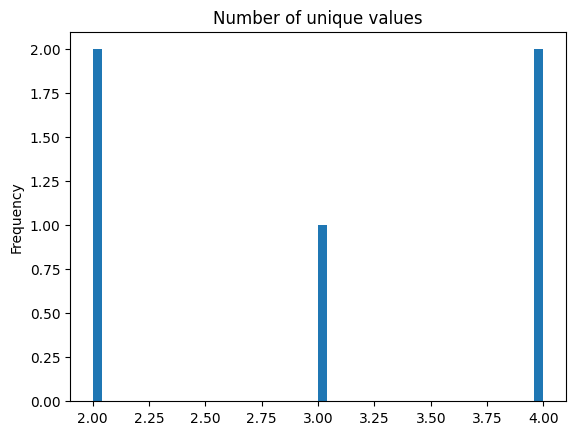

In [208]:
(X.select_dtypes(include='object').nunique()).plot.hist(bins=50, title="Number of unique values")

In [209]:
X.select_dtypes(include='object').nunique().sort_values().tail(25)

app_char_marital_status    2
app_char_cars              2
app_char_home_status       3
app_char_job_code          4
app_char_city              4
dtype: int64

## Null values filtering

### Remove features with a lot of null values

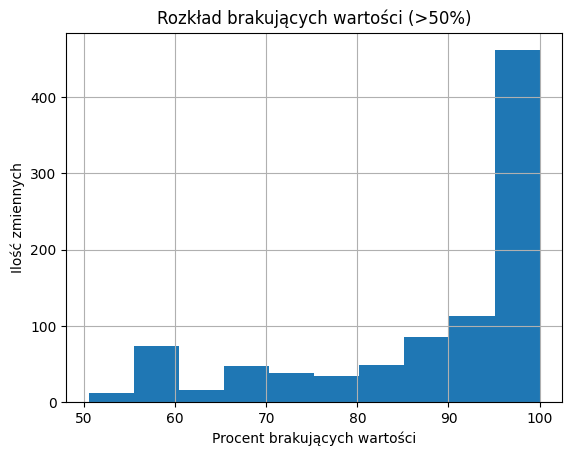

In [211]:
percent_missing = X.isna().mean() * 100
percent_missing_gt_50 = percent_missing[percent_missing > 50]

# Create hist 
ax = percent_missing_gt_50.hist()

# Add labels
ax.set_xlabel('Procent brakujących wartości')
ax.set_ylabel('Ilość zmiennych')
ax.set_title('Rozkład brakujących wartości (>50%)')
plt.show()

In [22]:
# TODO: remove columns with lots of nan 
# Calculate the percentage of missing values for each column
percent_missing = X.isna().mean() * 100

# Set the percentage of missing data that will constitute the threshold
threshold = 50

# Find columns that exceed the missing data threshold
columns_to_drop = percent_missing[percent_missing > threshold].index

# Remove these columns from the DataFrame
X.drop(columns=columns_to_drop,inplace=True)
columns_to_drop


Index(['act_state_12_CMax_Days', 'act_state_13_CMax_Days',
       'act_state_14_CMax_Days', 'act_state_15_CMax_Days',
       'act_state_16_CMax_Days', 'act_state_17_CMax_Days',
       'act_state_18_CMax_Days', 'act_state_19_CMax_Days',
       'act_state_20_CMax_Days', 'act_state_21_CMax_Days',
       ...
       'agr36_N_Cncr', 'agr36_Nmiss_Cncr', 'agr36_Range_Cncr',
       'agr36_Iqr_Cncr', 'agr36_Kurtosis_Cncr', 'ags36_Kurtosis_Cncr',
       'agr36_Skewness_Cncr', 'ags36_Skewness_Cncr', 'agr36_Std_Cncr',
       'ags36_Std_Cncr'],
      dtype='object', length=928)

In [23]:
X.shape

(88885, 1247)

## Null values to be imputed 

In [24]:
# Calculate the percentage of missing values for each column
percent_missing = X.isna().mean() * 100

# Set the percentage of missing data that will constitute the threshold
threshold_upper = 50
threshold_lower = 0

# Find columns that have more than 0% and less than or equal to 50% missing data
cols_within_threshold = percent_missing[(percent_missing > threshold_lower) & (percent_missing <= threshold_upper)].index

print(f"Number of columns with missing values > {threshold_lower}% and <= {threshold_upper}%: {len(cols_within_threshold)}")

column_list = list(cols_within_threshold)

len(column_list)


Number of columns with missing values > 0% and <= 50%: 377


377

### Check if there are rows with empty values for each variable or majority of them

<Axes: title={'center': 'Number of missing values for each row (1247 columns in total)'}, ylabel='Frequency'>

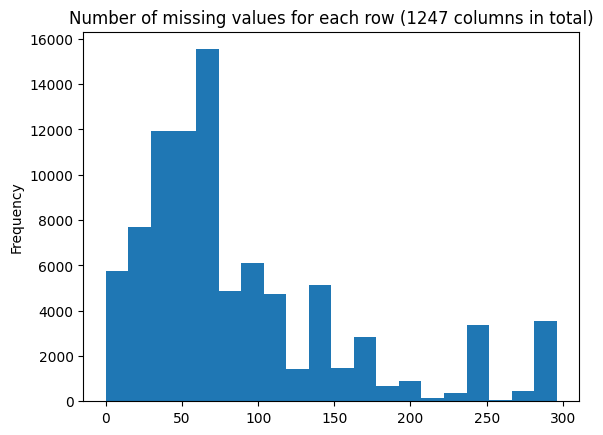

In [25]:
# 6000 rows with full columns info
(X.isna().sum(axis=1)).plot.hist(bins=20, title=f"Number of missing values for each row ({X.shape[1]} columns in total)")

## Building Pipelines for Data Processing

In [26]:
# Splitting the data according to 'is_validation'
X_train = X[X['is_validation'] == False].drop(columns=['is_validation'])
X_test = X[X['is_validation'] == True].drop(columns=['is_validation'])

# Ensure 'y' is a Series or a single-column DataFrame and split it
y_train = y[X['is_validation'] == False]
y_test = y[X['is_validation'] == True]

# Now you have your datasets split
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)
# Split your features explicitly
categorical_features = X_train.select_dtypes(include=["category", 'object']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=["category", 'object']).columns.tolist()

Training features shape: (44424, 1246)
Test features shape: (44461, 1246)
Training labels shape: (44424,)
Test labels shape: (44461,)


In [27]:
# Pipeline for numerical data
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())                
])

# Pipeline for categorical data
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                      
])

processing = ColumnTransformer(
    [('category', categorical_pipeline, selector(dtype_include=["category",'object'])),
     ('numerical', numeric_pipeline, selector(dtype_exclude=["category",'object']))
    ])

In [28]:
X_train_processed = processing.fit_transform(X_train)
X_test_processed = processing.transform(X_test)

In [29]:
feature_names = processing.get_feature_names_out()
print(len(feature_names))

1256


In [30]:
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

/var/folders/mp/nc48tbpj7bgdybncjc6n52s00000gn/T/ipykernel_54923/3653841931.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_counts.index, y=default_counts.values, palette='viridis')


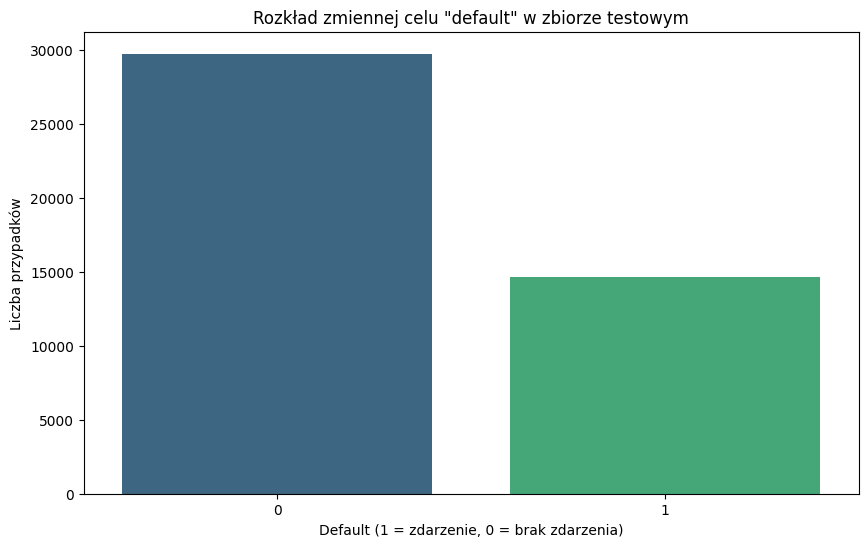

In [31]:
# target variable distribution
default_counts=y_test.value_counts()

# Bar chart for variable distribution: 'default'
plt.figure(figsize=(10, 6))
sns.barplot(x=default_counts.index, y=default_counts.values, palette='viridis')
#plt.title('Rozkład zmiennej celu "default" w zbiorze testowym')
plt.xlabel('Default (1 = zdarzenie, 0 = brak zdarzenia)')
plt.ylabel('Liczba przypadków')
plt.show()

/var/folders/mp/nc48tbpj7bgdybncjc6n52s00000gn/T/ipykernel_54923/1029685438.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_counts.index, y=default_counts.values, palette='viridis')


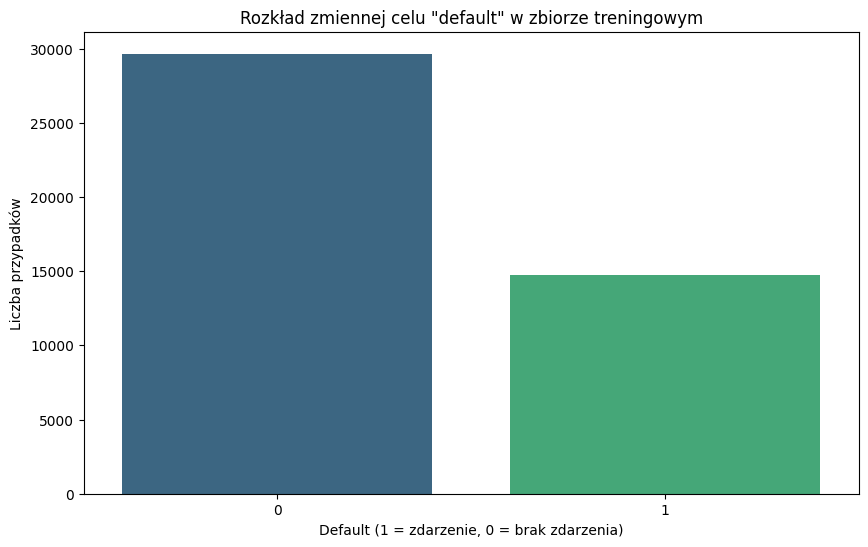

In [32]:
# target variable distribution
default_counts=y_train.value_counts()

# Bar chart for variable distribution: 'default'
plt.figure(figsize=(10, 6))
sns.barplot(x=default_counts.index, y=default_counts.values, palette='viridis')
#plt.title('Rozkład zmiennej celu "default" w zbiorze treningowym')
plt.xlabel('Default (1 = zdarzenie, 0 = brak zdarzenia)')
plt.ylabel('Liczba przypadków')
plt.show()

In [33]:
#Create Random Forest Model to conduct Feature Selection
rf = RandomForestClassifier(random_state= SEED)

# Step 2: Define param grid
param_grid_rf = {
    'n_estimators': Integer(30, 300),  
    'max_depth': Integer(2, 5),       
    'min_samples_leaf': [0.1, 0.2],   
    'max_features': ['log2', 'sqrt']   
}     

# Step 3: Tune hyperparameters
cv = StratifiedKFold(n_splits=5)
bayes_search = BayesSearchCV(rf, param_grid_rf, n_iter=20, cv=cv, verbose=3, random_state=SEED)

# Step 4: Fit the model
bayes_search.fit(X_train_processed_df, y_train)


/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/skopt/space/space.py:110: UserWarning: Dimension [0.1, 0.2] was inferred to Real(low=0.1, high=0.2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.1, 0.2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/skopt/space/space.py:110: UserWarning: Dimension [0.1, 0.2] was inferred to Real(low=0.1, high=0.2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.1, 0.2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/skopt/space/space.py:110: UserWarning: Dimension [0.1, 0.2] was 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.748 total time=   4.4s
[CV 2/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.751 total time=   4.2s
[CV 3/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.748 total time=   4.3s
[CV 4/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.753 total time=   4.3s
[CV 5/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.750 total time=   4.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=0.1303410109884175, n_estimators=287;, score=0.745 total time=  12.3s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=0.1303410109884175, n_estima

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=RandomForestClassifier(random_state=42), n_iter=20,
              random_state=42,
              search_spaces={'max_depth': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'max_features': ['log2', 'sqrt'],
                             'min_samples_leaf': [0.1, 0.2],
                             'n_estimators': Integer(low=30, high=300, prior='uniform', transform='normalize')},
              verbose=3)

Train Result:
Accuracy Score: 76.13%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.772665      0.719304  0.761278      0.745984      0.754932
recall         0.910286      0.461898  0.761278      0.686092      0.761278
f1-score       0.835849      0.562554  0.761278      0.699201      0.745027
support    29661.000000  14763.000000  0.761278  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[27000  2661]
 [ 7944  6819]]



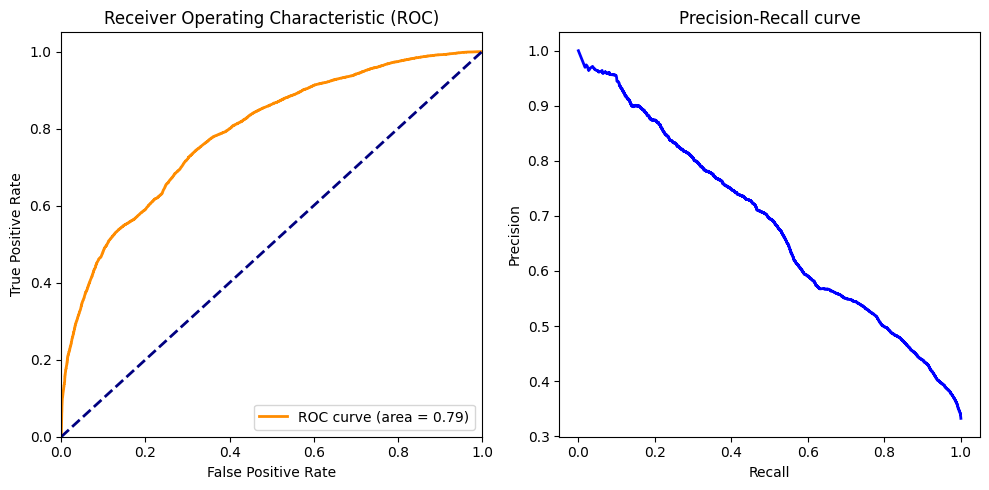

Average Decision Score: 0.33
Test Result:
Accuracy Score: 76.07%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.772433      0.716777  0.760734      0.744605      0.754045
recall         0.911088      0.456025  0.760734      0.683556      0.760734
f1-score       0.836051      0.557414  0.760734      0.696732      0.743989
support    29771.000000  14690.000000  0.760734  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[27124  2647]
 [ 7991  6699]]



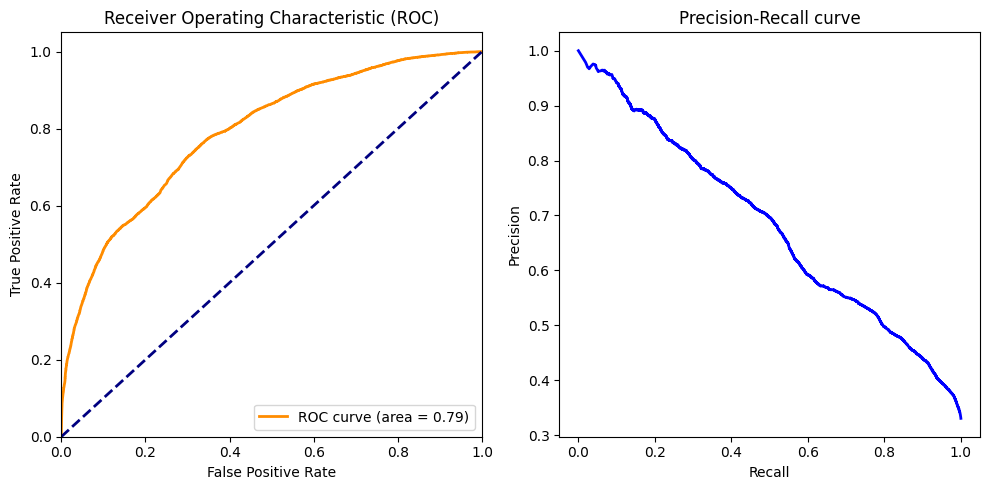

Average Decision Score: 0.33


In [35]:
# Step 5: Evaluate the Model
# y_train_pred = bayes_search.predict(X_train_processed_df)
# y_test_pred = bayes_search.predict(X_test_processed_df)

# print_score(y_train, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_fs = bayes_search.predict(X_train_processed_df)
y_test_pred_fs = bayes_search.predict(X_test_processed_df)

# Receive probability values
y_train_pred_proba_fs = bayes_search.predict_proba(X_train_processed_df)[:, 1]
y_test_pred_proba_fs = bayes_search.predict_proba(X_test_processed_df)[:, 1]

# show results for train dataset
print_score(y_train, y_train_pred_fs, y_train_pred_proba_fs, train=True)
# show results for test dataset
print_score(y_test, y_test_pred_fs, y_test_pred_proba_fs, train=False)
# Extract best parameters
print("Best params:", bayes_search.best_params_)

In [36]:
feature_names=X_train_processed_df.columns
best_rf = bayes_search.best_estimator_
feature_importances = best_rf.feature_importances_
print(len(feature_names))

1256


In [37]:
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

In [38]:
# check feature importance using permutation
# Compute Permutation Importance using test dataset
perm_importance = permutation_importance(best_rf, X_test_processed_df, y_test, n_repeats=10, random_state=SEED)

# Show results
for i in perm_importance.importances_mean.argsort()[::-1]:
    if perm_importance.importances_mean[i] - 2 * perm_importance.importances_std[i] > 0:
        print(f"Feature: {X_test_processed_df.columns[i]}")
        print(f"Importance: {perm_importance.importances_mean[i]:.4f} +/- {perm_importance.importances_std[i]:.4f}")

# Create DataFrame with Permutation Importance results
importance_df = pd.DataFrame({
    'Feature': X_test_processed_df.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
}).sort_values(by='Importance Mean', ascending=False)


Feature: numerical__act_cus_dueutl
Importance: 0.0029 +/- 0.0005
Feature: numerical__act_CMax_Due
Importance: 0.0017 +/- 0.0004
Feature: numerical__act_CMin_Due
Importance: 0.0015 +/- 0.0003
Feature: category__app_char_job_code_Retired
Importance: 0.0013 +/- 0.0002
Feature: numerical__act_state_1_CMin_Due
Importance: 0.0007 +/- 0.0002
Feature: numerical__ags3_n_cus_arrears
Importance: 0.0006 +/- 0.0003
Feature: numerical__act_age
Importance: 0.0003 +/- 0.0001
Feature: category__app_char_home_status_Owner
Importance: 0.0001 +/- 0.0000
Feature: numerical__ags3_Sum_CMin_Days
Importance: 0.0001 +/- 0.0000


### Compare Coverage: Permutation Importance with Random Forest Importances

In [39]:
# Sort both DataFrames by importance
importance_df.sort_values(by='Importance Mean', ascending=False, inplace=True)
permutation_sorted = importance_df[importance_df["Importance Mean"]>0]
feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
randomforest_imp_sorted = feature_importances_df[feature_importances_df["Importance"]>0]

In [40]:
# Select variables
permutation = permutation_sorted['Feature']
random_forest = randomforest_imp_sorted['Feature']
print(len(permutation),len(random_forest))


48 308


In [41]:
# Coverage percentage
common_features = set(permutation).intersection(set(random_forest))
coverage_percentage = len(common_features) / 308 * 100

print(f"Procentowe pokrycie: {coverage_percentage:.2f}%")

Procentowe pokrycie: 15.58%


In [42]:
print("Wspólne cechy:")
print(common_features)
print(len(common_features))

Wspólne cechy:
{'numerical__ags36_N_CMax_Days', 'numerical__act_state_1_CMin_Due', 'numerical__ags15_N_CMin_Days', 'numerical__ags36_Nmiss_CMax_Due', 'numerical__ags33_Sum_CMin_Days', 'category__app_char_job_code_Retired', 'numerical__ags6_N_CMin_Days', 'numerical__agr12_Sum_CMax_Due', 'numerical__ags15_Nmiss_CMax_Days', 'numerical__ags3_Sum_CMin_Days', 'numerical__ags30_Sum_CMin_Days', 'numerical__ags3_Std_CMax_Due', 'numerical__ags12_N_CMin_Due', 'numerical__act_cus_seniority', 'numerical__ags3_Pctl75_CMin_Due', 'numerical__ags27_Nmiss_CMin_Due', 'numerical__act_cus_pins', 'numerical__act_age', 'numerical__act_cus_utl', 'numerical__ags12_N_CMax_Days', 'numerical__ags30_Nmiss_CMin_Due', 'numerical__ags30_Nmiss_CMax_Days', 'numerical__app_number_of_children', 'category__app_char_home_status_Owner', 'numerical__ags3_Pctl95_CMax_Due', 'numerical__ags12_N_CMin_Days', 'numerical__act_CMin_Due', 'numerical__ags18_N_CMin_Days', 'numerical__agr6_Pctl95_CMin_Due', 'numerical__ags24_N_CMin_Days

### Selection of the number of variables based on their cumulative importance

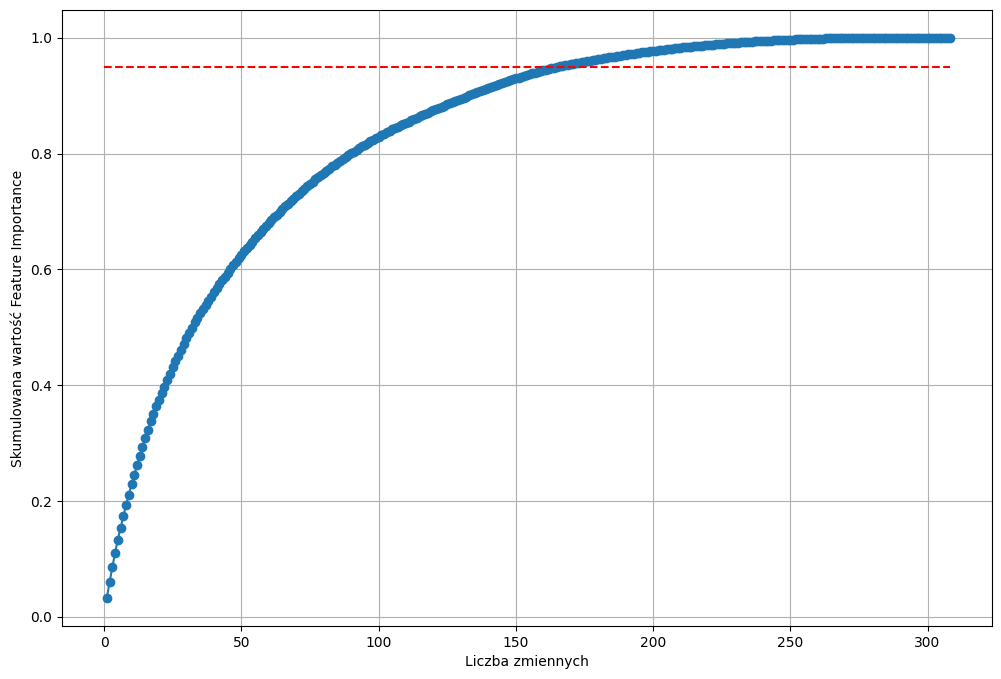

In [266]:
import warnings
warnings.filterwarnings("ignore")

feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
randomforest_imp_sorted = feature_importances_df[feature_importances_df["Importance"] > 0]

# Calculating the cumulative importance of features and the cumulative number of variables
randomforest_imp_sorted['Cumulative Importance'] = randomforest_imp_sorted['Importance'].cumsum()
randomforest_imp_sorted['Number of Features'] = np.arange(1, len(randomforest_imp_sorted) + 1)

# Graph of cumulative feature importance with number of variables
plt.figure(figsize=(12, 8))
plt.plot(randomforest_imp_sorted['Number of Features'], randomforest_imp_sorted['Cumulative Importance'], marker='o')
plt.xlabel('Liczba zmiennych')
plt.ylabel('Skumulowana wartość Feature Importance')
# plt.title('Skumulowane Feature Importance')
plt.hlines(y = 0.95, xmin=0, xmax=len(randomforest_imp_sorted), color = 'r', linestyles = 'dashed')
plt.grid(True)
plt.show()



In [44]:
print(randomforest_imp_sorted[randomforest_imp_sorted["Number of Features"]==165][["Number of Features","Cumulative Importance"]])
print(randomforest_imp_sorted[randomforest_imp_sorted["Number of Features"]==140][["Number of Features","Cumulative Importance"]])
print(randomforest_imp_sorted[randomforest_imp_sorted["Number of Features"]==120][["Number of Features","Cumulative Importance"]])
print(randomforest_imp_sorted[randomforest_imp_sorted["Number of Features"]==100][["Number of Features","Cumulative Importance"]])
print(randomforest_imp_sorted[randomforest_imp_sorted["Number of Features"]==80][["Number of Features","Cumulative Importance"]])
print(randomforest_imp_sorted[randomforest_imp_sorted["Number of Features"]==60][["Number of Features","Cumulative Importance"]])
print(randomforest_imp_sorted[randomforest_imp_sorted["Number of Features"]==40][["Number of Features","Cumulative Importance"]])
print(randomforest_imp_sorted[randomforest_imp_sorted["Number of Features"]==20][["Number of Features","Cumulative Importance"]])


      Number of Features  Cumulative Importance
1030                 165               0.949409
     Number of Features  Cumulative Importance
549                 140               0.912965
     Number of Features  Cumulative Importance
210                 120               0.874671
     Number of Features  Cumulative Importance
505                 100               0.829033
     Number of Features  Cumulative Importance
889                  80               0.766906
     Number of Features  Cumulative Importance
303                  60                0.67951
     Number of Features  Cumulative Importance
123                  40               0.560015
     Number of Features  Cumulative Importance
173                  20               0.374883


In [45]:
randomforest_imp_sorted.head(165)

Feature  Importance  Cumulative Importance  \
26               numerical__act_cus_dueutl    0.032773               0.032773   
52                 numerical__act_CMax_Due    0.026392               0.059166   
116          numerical__agr3_Mean_CMax_Due    0.025928               0.085094   
77                 numerical__act_CMin_Due    0.024793               0.109886   
165        numerical__ags3_Pctl75_CMin_Due    0.022640               0.132527   
114        numerical__agr3_Median_CMax_Due    0.020858               0.153385   
1077         numerical__ags3_n_cus_arrears    0.019811               0.173196   
65         numerical__act_state_1_CMin_Due    0.019046               0.192242   
3      category__app_char_job_code_Retired    0.018330               0.210573   
169        numerical__ags3_Median_CMin_Due    0.017841               0.228414   
117          numerical__ags3_Mean_CMax_Due    0.016710               0.245123   
171          numerical__ags3_Mean_CMin_Due    0.016258               0.261381   
113        numerical__ags3_Pctl95_CMax_Due    0.015722               0.277103   
119           numerical__ags3_Max_CMax_Due    0.015542               0.292645   
66         numerical__act_state_2_CMin_Due    0.015246               0.307891   
118           numerical__agr3_Max_CMax_Due    0.015209               0.323100   
111        numerical__ags3_Pctl75_CMax_Due    0.014184               0.337284   
41         numerical__act_state_2_CMax_Due    0.012999               0.350283   
168        numerical__agr3_Median_CMin_Due    0.012933               0.363216   
173           numerical__ags3_Max_CMin_Due    0.011667               0.374883   
121           numerical__ags3_Min_CMax_Due    0.011332               0.386215   
106         numerical__agr3_Pctl5_CMax_Due    0.011286               0.397502   
15                      numerical__act_age    0.011285               0.408787   
163        numerical__ags3_Pctl25_CMin_Due    0.011103               0.419890   
166        numerical__agr3_Pctl95_CMin_Due    0.010958               0.430848   
359           numerical__ags9_Std_CMin_Due    0.010225               0.441074   
177           numerical__ags3_Sum_CMin_Due    0.010041               0.451115   
215          numerical__ags6_Mean_CMax_Due    0.009985               0.461100   
131           numerical__ags3_Std_CMax_Due    0.009858               0.470959   
150            numerical__ags3_N_CMin_Days    0.009714               0.480673   
170          numerical__agr3_Mean_CMin_Due    0.009632               0.490305   
109        numerical__ags3_Pctl25_CMax_Due    0.009028               0.499333   
176           numerical__agr3_Sum_CMin_Due    0.008994               0.508327   
127         numerical__ags3_Range_CMax_Due    0.007840               0.516167   
110        numerical__agr3_Pctl75_CMax_Due    0.007640               0.523807   
27                   numerical__act_cus_cc    0.007448               0.531255   
130           numerical__agr3_Std_CMax_Due    0.007372               0.538627   
129           numerical__ags3_Iqr_CMax_Due    0.007259               0.545887   
40         numerical__act_state_1_CMax_Due    0.007074               0.552961   
123           numerical__ags3_Sum_CMax_Due    0.007054               0.560015   
112        numerical__agr3_Pctl95_CMax_Due    0.007051               0.567066   
108        numerical__agr3_Pctl25_CMax_Due    0.006886               0.573951   
120           numerical__agr3_Min_CMax_Due    0.006773               0.580724   
263           numerical__ags6_Sum_CMin_Due    0.006699               0.587423   
107         numerical__ags3_Pctl5_CMax_Due    0.006668               0.594091   
172           numerical__agr3_Max_CMin_Due    0.006495               0.600586   
164        numerical__agr3_Pctl75_CMin_Due    0.006418               0.607004   
17       numerical__app_number_of_children    0.006226               0.613229   
25                  numerical__act_cus_utl    0.006109            

In [46]:
list_165= list(randomforest_imp_sorted.head(165)["Feature"])
len(list_165)

165

In [212]:
list_165

['numerical__act_cus_dueutl',
 'numerical__act_CMax_Due',
 'numerical__agr3_Mean_CMax_Due',
 'numerical__act_CMin_Due',
 'numerical__ags3_Pctl75_CMin_Due',
 'numerical__agr3_Median_CMax_Due',
 'numerical__ags3_n_cus_arrears',
 'numerical__act_state_1_CMin_Due',
 'category__app_char_job_code_Retired',
 'numerical__ags3_Median_CMin_Due',
 'numerical__ags3_Mean_CMax_Due',
 'numerical__ags3_Mean_CMin_Due',
 'numerical__ags3_Pctl95_CMax_Due',
 'numerical__ags3_Max_CMax_Due',
 'numerical__act_state_2_CMin_Due',
 'numerical__agr3_Max_CMax_Due',
 'numerical__ags3_Pctl75_CMax_Due',
 'numerical__act_state_2_CMax_Due',
 'numerical__agr3_Median_CMin_Due',
 'numerical__ags3_Max_CMin_Due',
 'numerical__ags3_Min_CMax_Due',
 'numerical__agr3_Pctl5_CMax_Due',
 'numerical__act_age',
 'numerical__ags3_Pctl25_CMin_Due',
 'numerical__agr3_Pctl95_CMin_Due',
 'numerical__ags9_Std_CMin_Due',
 'numerical__ags3_Sum_CMin_Due',
 'numerical__ags6_Mean_CMax_Due',
 'numerical__ags3_Std_CMax_Due',
 'numerical__ags3_N

In [ ]:
# Permutaton importance vs random forest feature importance after selecting 165 features: 48/165*100 = ok. 30%

In [47]:
# Scenario 1
X_train_s1 = X_train_processed_df[list_165]
X_test_s1 = X_test_processed_df[list_165]


In [48]:
X_train_s1.reset_index(drop=True,inplace=True)
X_test_s1.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)


## Correlation Analysis

In [66]:
#another scenario; compare models without conducting Corelation Analysis

In [49]:
dataset_corr=X_train_s1.corr()
dataset_corr.head(50)


numerical__act_cus_dueutl  \
numerical__act_cus_dueutl                             1.000000   
numerical__act_CMax_Due                               0.988222   
numerical__agr3_Mean_CMax_Due                         0.848089   
numerical__act_CMin_Due                               0.989912   
numerical__ags3_Pctl75_CMin_Due                       0.898494   
numerical__agr3_Median_CMax_Due                       0.783464   
numerical__ags3_n_cus_arrears                         0.811740   
numerical__act_state_1_CMin_Due                       0.989912   
category__app_char_job_code_Retired                  -0.177442   
numerical__ags3_Median_CMin_Due                       0.853056   
numerical__ags3_Mean_CMax_Due                         0.850800   
numerical__ags3_Mean_CMin_Due                         0.902677   
numerical__ags3_Pctl95_CMax_Due                       0.814120   
numerical__ags3_Max_CMax_Due                          0.814120   
numerical__act_state_2_CMin_Due                       0.805715   
numerical__agr3_Max_CMax_Due                          0.811483   
numerical__ags3_Pctl75_CMax_Due                       0.814120   
numerical__act_state_2_CMax_Due                       0.729435   
numerical__agr3_Median_CMin_Due                       0.850629   
numerical__ags3_Max_CMin_Due                          0.898494   
numerical__ags3_Min_CMax_Due                          0.758119   
numerical__agr3_Pctl5_CMax_Due                        0.758119   
numerical__act_age                                   -0.154116   
numerical__ags3_Pctl25_CMin_Due                       0.761846   
numerical__agr3_Pctl95_CMin_Due                       0.896272   
numerical__ags9_Std_CMin_Due                          0.638362   
numerical__ags3_Sum_CMin_Due                          0.902463   
numerical__ags6_Mean_CMax_Due                         0.663830   
numerical__ags3_Std_CMax_Due                          0.561530   
numerical__ags3_N_CMin_Days                          -0.643171   
numerical__agr3_Mean_CMin_Due                         0.900027   
numerical__ags3_Pctl25_CMax_Due                       0.758119   
numerical__agr3_Sum_CMin_Due                          0.900027   
numerical__ags3_Range_CMax_Due                        0.576152   
numerical__agr3_Pctl75_CMax_Due                       0.811483   
numerical__act_cus_cc                                -0.113965   
numerical__agr3_Std_CMax_Due                          0.561152   
numerical__ags3_Iqr_CMax_Due                          0.576152   
numerical__act_state_1_CMax_Due                       0.988222   
numerical__ags3_Sum_CMax_Due                          0.850433   
numerical__agr3_Pctl95_CMax_Due                       0.811483   
numerical__agr3_Pctl25_CMax_Due                       0.758119   
numerical__agr3_Min_CMax_Due                          0.758119   
numerical__ags6_Sum_CMin_Due                          0.764463   
numerical__ags3_Pctl5_CMax_Due                        0.758119   
numerical__agr3_Max_CMin_Due                          0.896272   
numerical__agr3_Pctl75_CMin_Due                       0.896272   
numerical__app_number_of_children                     0.131839   
numerical__act_cus_utl                                0.040628   
numerical__agr3_Sum_CMax_Due                          0.848089   

                                     numerical__act_CMax_Due  \
numerical__act_cus_dueutl                           0.988222   
numerical__act_CMax_Due                             1.000000   
numerical__agr3_Mean_CMax_Due                       0.861774   
numerical__act_CMin_Due                             0.957451   
numerical__ags3_Pctl75_CMin_Due                     0.870280   
numerical__agr3_Median_CMax_Due                     0.796165   
numerical__ags3_n_cus_arrears                       0.822697   
numerical__act_state_1_CMin_Due                     0.957451   
category__app_char_job_code_Retired                -0.169811   
numerical__ags3_Median_CMin_Du

In [50]:
# Calculating the correlation matrix
corr_matrix = dataset_corr.corr().abs()

# Setting the threshold
threshold = 0.9

# Find pairs of variables that exceed the threshold
pairs_to_drop = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:
            pairs_to_drop.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Create a DataFrame with pairs of variables and their correlations
correlation_df = pd.DataFrame(pairs_to_drop, columns=['Zmienna 1', 'Zmienna 2', 'Korelacja'])

# Show results
print(len(correlation_df["Zmienna 1"].unique()),len(correlation_df["Zmienna 2"].unique()))


159 157


In [51]:
correlation_df["Zmienna 2"].unique()

array(['numerical__act_cus_dueutl', 'numerical__act_CMax_Due',
       'numerical__agr3_Mean_CMax_Due', 'numerical__act_CMin_Due',
       'numerical__ags3_Pctl75_CMin_Due',
       'numerical__agr3_Median_CMax_Due', 'numerical__ags3_n_cus_arrears',
       'numerical__act_state_1_CMin_Due',
       'numerical__ags3_Median_CMin_Due', 'numerical__ags3_Mean_CMax_Due',
       'numerical__ags3_Mean_CMin_Due', 'numerical__ags3_Pctl95_CMax_Due',
       'numerical__ags3_Max_CMax_Due', 'numerical__act_state_2_CMin_Due',
       'numerical__agr3_Max_CMax_Due', 'numerical__ags3_Pctl75_CMax_Due',
       'numerical__act_state_2_CMax_Due',
       'numerical__agr3_Median_CMin_Due', 'numerical__ags3_Max_CMin_Due',
       'numerical__ags3_Min_CMax_Due',
       'category__app_char_job_code_Retired',
       'numerical__agr3_Pctl5_CMax_Due',
       'numerical__ags3_Pctl25_CMin_Due',
       'numerical__agr3_Pctl95_CMin_Due', 'numerical__ags9_Std_CMin_Due',
       'numerical__ags3_Sum_CMin_Due', 'numerical__ags6

In [52]:
X_train_s1_corr = X_train_s1.drop(columns=correlation_df["Zmienna 2"].unique())
X_test_s1_corr = X_test_s1.drop(columns=correlation_df["Zmienna 2"].unique())
X_train_s1_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   numerical__act_cus_cc                 44424 non-null  float64
 1   numerical__app_number_of_children     44424 non-null  float64
 2   numerical__app_income                 44424 non-null  float64
 3   numerical__ags3_Sum_CMax_Days         44424 non-null  float64
 4   category__app_char_home_status_Owner  44424 non-null  float64
 5   numerical__agr6_Range_CMax_Due        44424 non-null  float64
 6   numerical__ags15_Sum_CMin_Days        44424 non-null  float64
 7   numerical__ags36_Std_CMax_Due         44424 non-null  float64
dtypes: float64(8)
memory usage: 2.7 MB


# Smote

In [58]:
#another scenario; compare models without performing SMOTE
#use X_train_gt_x2, y_train instead X_train_smote, y_train_smote 

In [53]:
smote = SMOTE(random_state=SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train_s1, y_train)

# Models

# Logistic Regression

In [214]:
# Step1: Define the model
model_lr = LogisticRegression(random_state=SEED)

In [215]:
# Step 2: Define param grid
param_grid_lr = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),  
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

In [216]:
# Step 3: Tune hyperparameters
cv = StratifiedKFold(n_splits=5)
bayes_search = BayesSearchCV(model_lr, param_grid_lr, n_iter=20, cv=cv, verbose=3, random_state=SEED)

### LR Smote

In [217]:
# Step 4: Fit the model
bayes_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 1/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.757 total time=   5.1s
[CV 2/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.773 total time=   3.6s
[CV 3/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.767 total time=   5.2s
[CV 4/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.764 total time=   4.4s
[CV 5/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.777 total time=   3.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.758 total time=   4.1s
[CV 2/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.771 total time=   7.1s
[CV 3/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.766 total time=   9.4s
[CV 4/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.765 total time=   4.0s
[CV 5/5] END C=11185.625288472094, penalty=l2, solver=newton-cg

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=LogisticRegression(random_state=42), n_iter=20,
              random_state=42,
              search_spaces={'C': Real(low=1e-06, high=1000000.0, prior='log-uniform', transform='normalize'),
                             'penalty': ['l2'],
                             'solver': ['newton-cg', 'lbfgs', 'liblinear']},
              verbose=3)

Train Result:
Accuracy Score: 76.95%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.758548      0.781337  0.769462      0.769943      0.769943
recall         0.790567      0.748356  0.769462      0.769462      0.769462
f1-score       0.774227      0.764491  0.769462      0.769359      0.769359
support    29661.000000  29661.000000  0.769462  59322.000000  59322.000000
_______________________________________________
Confusion Matrix: 
 [[23449  6212]
 [ 7464 22197]]



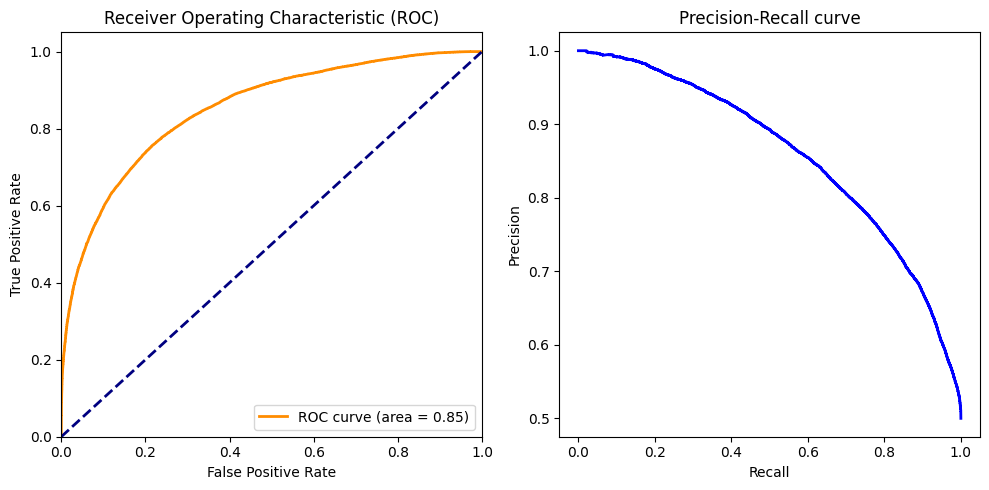

Average Decision Score: 0.50
Test Result:
Accuracy Score: 77.39%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.861194      0.635108  0.773914      0.748151      0.786495
recall         0.789627      0.742069  0.773914      0.765848      0.773914
f1-score       0.823859      0.684435  0.773914      0.754147      0.777793
support    29771.000000  14690.000000  0.773914  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[23508  6263]
 [ 3789 10901]]



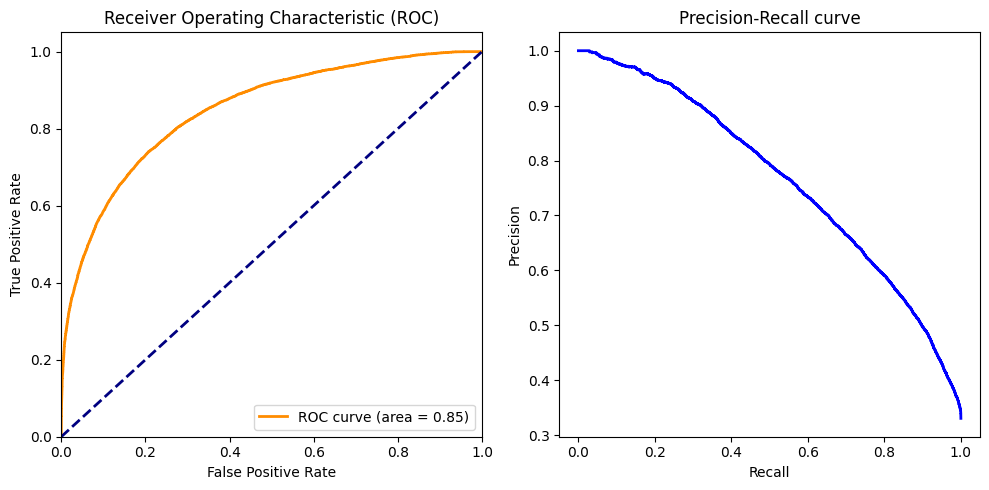

Average Decision Score: 0.44
Best params: OrderedDict([('C', 0.023576507976064233), ('penalty', 'l2'), ('solver', 'lbfgs')])


In [218]:
# # Step 5: Evaluate the model
# y_train_pred = bayes_search.predict(X_train_smote)
# y_test_pred = bayes_search.predict(X_test_gt_x2)

# print_score(y_train_smote, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)


# Step 5: Evaluate the model
y_train_pred_s_lr = bayes_search.predict(X_train_smote)
y_test_pred_s_lr = bayes_search.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_s_lr = bayes_search.predict_proba(X_train_smote)[:, 1]
y_test_pred_proba_s_lr = bayes_search.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train_smote, y_train_pred_s_lr, y_train_pred_proba_s_lr, train=True)
# Display results for the test set
print_score(y_test, y_test_pred_s_lr, y_test_pred_proba_s_lr, train=False)
# Extract best parameters
print("Best params:", bayes_search.best_params_)

### LR No Smote and No Corr

In [219]:
# Check Logistic Regression model after removing majority highly correlated variables - it gives only 7 variables
bayes_search_corr = BayesSearchCV(model_lr, param_grid_lr, n_iter=20, cv=cv, verbose=3, random_state=SEED)
bayes_search_corr.fit(X_train_s1_corr, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.739 total time=   0.1s
[CV 2/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.738 total time=   0.1s
[CV 3/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.741 total time=   0.1s
[CV 4/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.740 total time=   0.1s
[CV 5/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.740 total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.739 total time=   0.1s
[CV 2/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.738 total time=   0.0s
[CV 3/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.741 total time=   0.0s
[CV 4/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.740 total time=   0.1s
[CV 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=LogisticRegression(random_state=42), n_iter=20,
              random_state=42,
              search_spaces={'C': Real(low=1e-06, high=1000000.0, prior='log-uniform', transform='normalize'),
                             'penalty': ['l2'],
                             'solver': ['newton-cg', 'lbfgs', 'liblinear']},
              verbose=3)

Train Result:
Accuracy Score: 74.05%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.760240      0.668753  0.740501      0.714497      0.729837
recall         0.892957      0.434194  0.740501      0.663575      0.740501
f1-score       0.821271      0.526532  0.740501      0.673902      0.723323
support    29661.000000  14763.000000  0.740501  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[26486  3175]
 [ 8353  6410]]



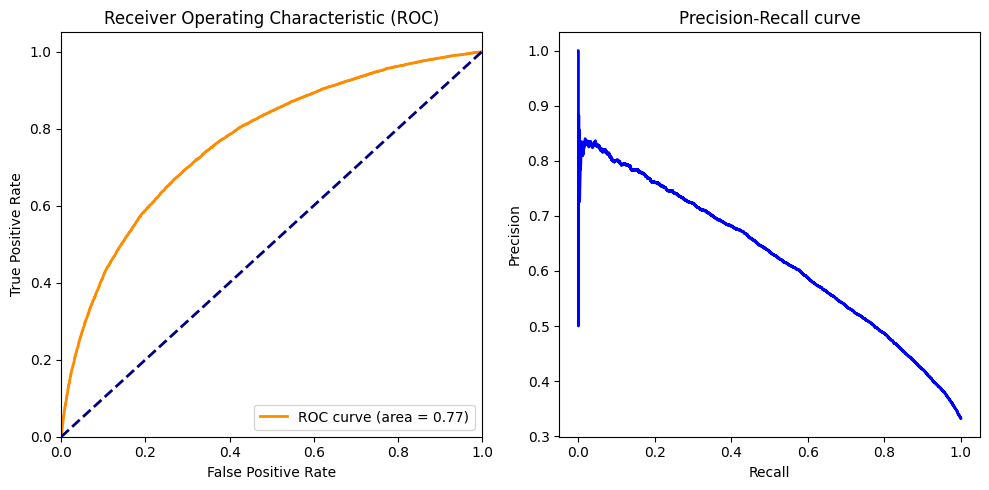

Average Decision Score: 0.33
Test Result:
Accuracy Score: 73.70%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.759952      0.654493   0.73696      0.707222      0.725108
recall         0.887508      0.431858   0.73696      0.659683      0.736960
f1-score       0.818792      0.520363   0.73696      0.669577      0.720190
support    29771.000000  14690.000000   0.73696  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[26422  3349]
 [ 8346  6344]]



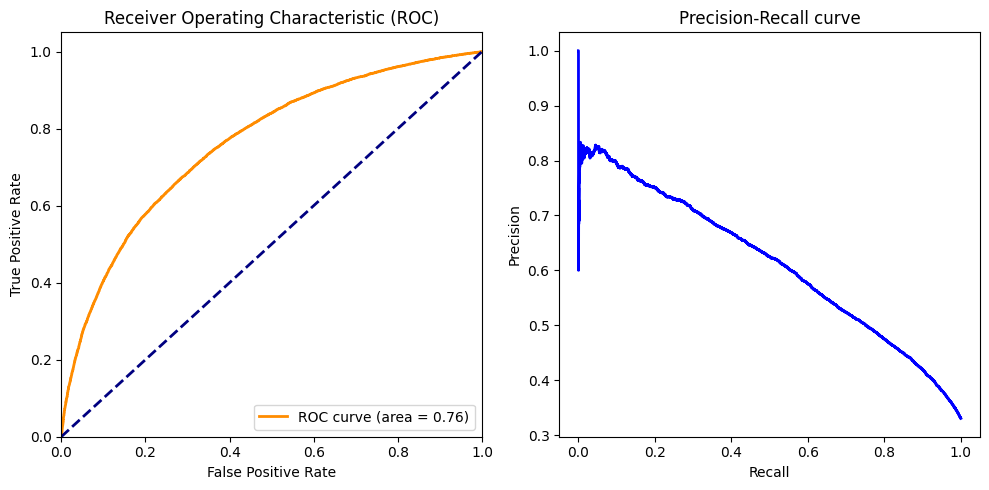

Average Decision Score: 0.33
Best params: OrderedDict([('C', 0.009731208338533432), ('penalty', 'l2'), ('solver', 'newton-cg')])


In [220]:
# # Evaluate the model
# y_train_pred = bayes_search_corr.predict(X_train_smote_corr)
# y_test_pred = bayes_search_corr.predict(X_test_gt_x2_corr)

# print_score(y_train_smote_corr, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_c_lr = bayes_search_corr.predict(X_train_s1_corr)
y_test_pred_c_lr = bayes_search_corr.predict(X_test_s1_corr)

# Get prediction probabilities
y_train_pred_proba_c_lr = bayes_search_corr.predict_proba(X_train_s1_corr)[:, 1]
y_test_pred_proba_c_lr = bayes_search_corr.predict_proba(X_test_s1_corr)[:, 1]

# Display results for the training set
print_score(y_train, y_train_pred_c_lr, y_train_pred_proba_c_lr, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_c_lr, y_test_pred_proba_c_lr, train=False)
# Extract best parameters
print("Best params:", bayes_search_corr.best_params_)


### LR NO SMOTE

In [221]:
# Check Logistic Regression model without using SMOTE
bayes_search_no_smote = BayesSearchCV(model_lr, param_grid_lr, n_iter=20, cv=cv, verbose=3, random_state=SEED)
bayes_search_no_smote.fit(X_train_s1, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.798 total time=   2.9s
[CV 2/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.798 total time=   2.9s
[CV 3/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.797 total time=   3.0s
[CV 4/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.792 total time=   3.1s
[CV 5/5] END C=0.08341564384216595, penalty=l2, solver=liblinear;, score=0.802 total time=   5.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.799 total time=   7.8s
[CV 2/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.798 total time=   6.2s
[CV 3/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.797 total time=   4.6s
[CV 4/5] END C=11185.625288472094, penalty=l2, solver=newton-cg;, score=0.793 total time=   4.7s
[CV 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=LogisticRegression(random_state=42), n_iter=20,
              random_state=42,
              search_spaces={'C': Real(low=1e-06, high=1000000.0, prior='log-uniform', transform='normalize'),
                             'penalty': ['l2'],
                             'solver': ['newton-cg', 'lbfgs', 'liblinear']},
              verbose=3)

Train Result:
Accuracy Score: 79.90%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.813394      0.756983  0.798983      0.785188      0.794647
recall         0.907016      0.581928  0.798983      0.744472      0.798983
f1-score       0.857657      0.658012  0.798983      0.757835      0.791311
support    29661.000000  14763.000000  0.798983  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[26903  2758]
 [ 6172  8591]]



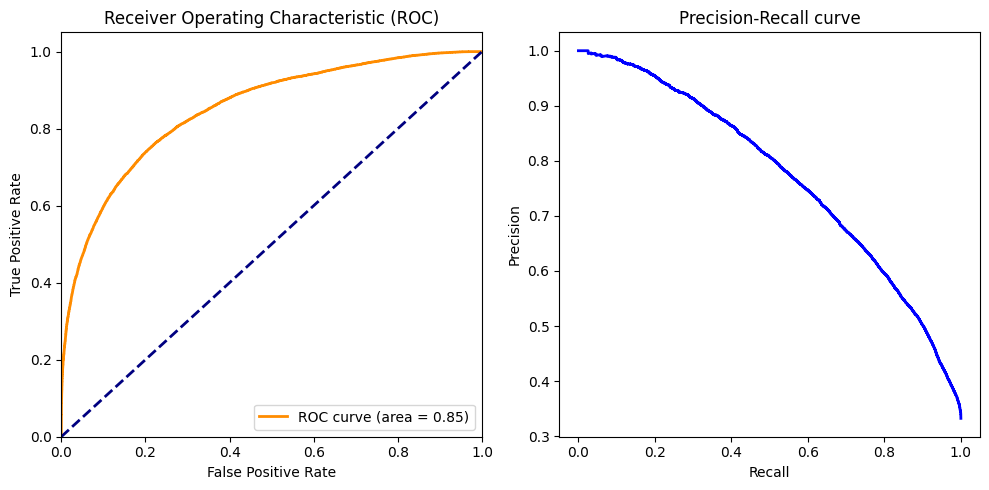

Average Decision Score: 0.33
Test Result:
Accuracy Score: 79.61%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.811969      0.749446  0.796113      0.780707      0.791311
recall         0.905109      0.575221  0.796113      0.740165      0.796113
f1-score       0.856013      0.650876  0.796113      0.753445      0.788235
support    29771.000000  14690.000000  0.796113  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[26946  2825]
 [ 6240  8450]]



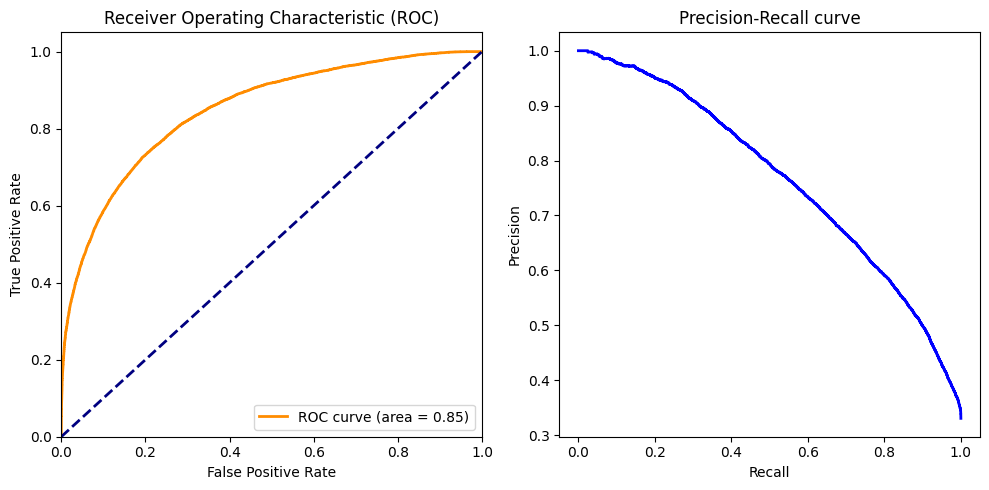

Average Decision Score: 0.33
Best params: OrderedDict([('C', 0.5507752527200831), ('penalty', 'l2'), ('solver', 'liblinear')])


In [222]:
# # Evaluate the model
# y_train_pred = bayes_search_no_smote.predict(X_train_gt_x2)
# y_test_pred = bayes_search_no_smote.predict(X_test_gt_x2)

# print_score(y_train, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)


# Step 5: Evaluate the model
y_train_pred_ns_lr = bayes_search_no_smote.predict(X_train_s1)
y_test_pred_ns_lr = bayes_search_no_smote.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_ns_lr = bayes_search_no_smote.predict_proba(X_train_s1)[:, 1]
y_test_pred_proba_ns_lr = bayes_search_no_smote.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train, y_train_pred_ns_lr, y_train_pred_proba_ns_lr, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_ns_lr, y_test_pred_proba_ns_lr, train=False)
# Extract best parameters
print("Best params:", bayes_search_no_smote.best_params_)


#### Compare  LR for 3 scenarios: with smote; without smote; nosmote and no correlated variables

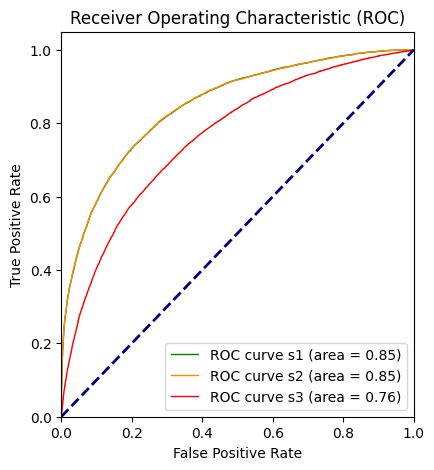

In [223]:
fpr1, tpr1, _ = roc_curve(y_test, y_test_pred_proba_s_lr)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_test_pred_proba_ns_lr)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_test_pred_proba_c_lr)
roc_auc3 = auc(fpr3, tpr3)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr1, tpr1, color='green', lw=1, label=f'ROC curve s1 (area = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label=f'ROC curve s2 (area = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='red', lw=1, label=f'ROC curve s3 (area = {roc_auc3:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Decision Tree

### DT Smote

In [224]:
# Step 1: Define the model
model_dt = DecisionTreeClassifier(random_state= SEED)

In [225]:
# Step 2: Define param grid
params_dt = {'max_depth': Integer(3, 15),
             'min_samples_leaf': Integer(1, 2000),
             'max_features': [0.2, 0.4,0.6, 0.8, 1.0]            }

In [226]:
# Step 3: Tune hyperparameters
cv = StratifiedKFold(n_splits=5)
bayes_search = BayesSearchCV(model_dt, params_dt, n_iter=20, cv=cv, verbose=3, random_state=SEED)

In [227]:
# Step 4: Fit the model
bayes_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.739 total time=   1.2s
[CV 2/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.761 total time=   0.9s
[CV 3/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.763 total time=   0.9s
[CV 4/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.772 total time=   0.8s
[CV 5/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.784 total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.756 total time=   1.8s
[CV 2/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.764 total time=   1.7s
[CV 3/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.778 total time=   1.6s
[CV 4/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.788 total time

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=DecisionTreeClassifier(random_state=42), n_iter=20,
              random_state=42,
              search_spaces={'max_depth': Integer(low=3, high=15, prior='uniform', transform='normalize'),
                             'max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
                             'min_samples_leaf': Integer(low=1, high=2000, prior='uniform', transform='normalize')},
              verbose=3)

Train Result:
Accuracy Score: 79.72%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.785208      0.810263  0.797208      0.797736      0.797736
recall         0.818246      0.776171  0.797208      0.797208      0.797208
f1-score       0.801387      0.792851  0.797208      0.797119      0.797119
support    29661.000000  29661.000000  0.797208  59322.000000  59322.000000
_______________________________________________
Confusion Matrix: 
 [[24270  5391]
 [ 6639 23022]]



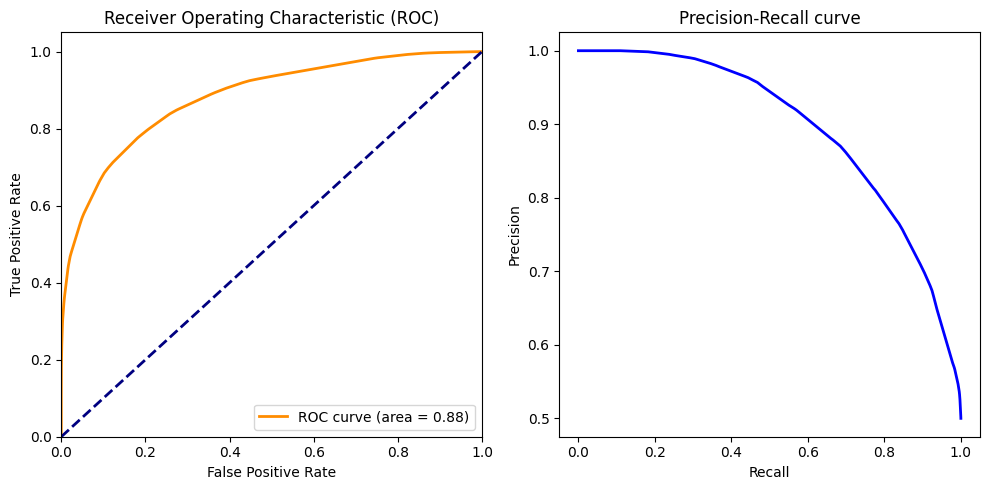

Average Decision Score: 0.50
Test Result:
Accuracy Score: 78.01%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.849746      0.654762  0.780122      0.752254      0.785323
recall         0.815895      0.707624  0.780122      0.761759      0.780122
f1-score       0.832477      0.680168  0.780122      0.756322      0.782153
support    29771.000000  14690.000000  0.780122  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[24290  5481]
 [ 4295 10395]]



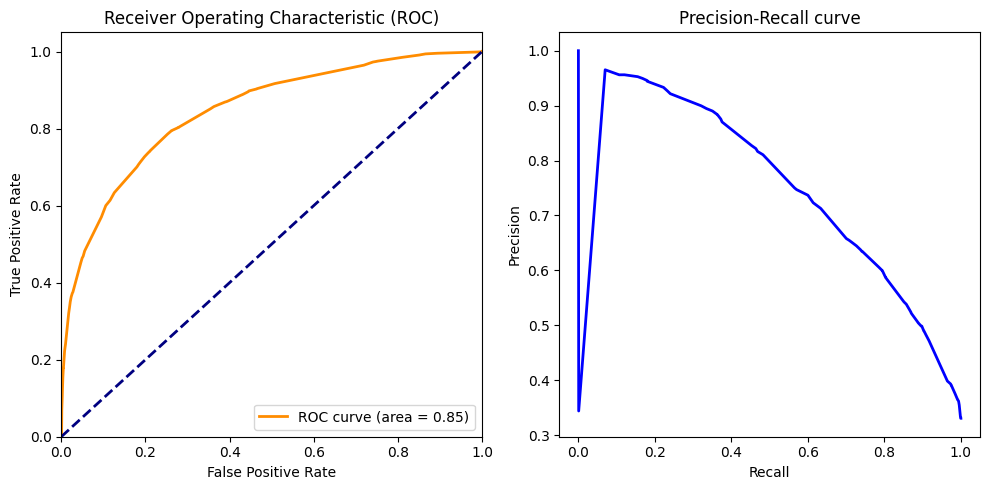

Average Decision Score: 0.40
Best params: OrderedDict([('max_depth', 7), ('max_features', 1.0), ('min_samples_leaf', 1)])


In [228]:
# # Step 5: Evaluate the model
# y_train_pred = bayes_search.predict(X_train_smote)
# y_test_pred = bayes_search.predict(X_test_gt_x2)

# print_score(y_train_smote, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)


# Step 5: Evaluate the model
y_train_pred_s_dt = bayes_search.predict(X_train_smote)
y_test_pred_s_dt = bayes_search.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_s_dt = bayes_search.predict_proba(X_train_smote)[:, 1]
y_test_pred_proba_s_dt = bayes_search.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train_smote, y_train_pred_s_dt, y_train_pred_proba_s_dt, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_s_dt, y_test_pred_proba_s_dt, train=False)
# Extract best parameters
print("Best params:", bayes_search.best_params_)


### DT No Smote No Corr

In [229]:
# Check DT model after removing majority highly correlated variables - it gives only 7 variables

bayes_search_corr = BayesSearchCV(model_dt, params_dt, n_iter=20, cv=cv, verbose=3, random_state=SEED)
bayes_search_corr.fit(X_train_s1_corr, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.727 total time=   0.1s
[CV 2/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.739 total time=   0.1s
[CV 3/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.729 total time=   0.1s
[CV 4/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.737 total time=   0.1s
[CV 5/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.745 total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.737 total time=   0.1s
[CV 2/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.751 total time=   0.1s
[CV 3/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.745 total time=   0.1s
[CV 4/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.750 total time

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=DecisionTreeClassifier(random_state=42), n_iter=20,
              random_state=42,
              search_spaces={'max_depth': Integer(low=3, high=15, prior='uniform', transform='normalize'),
                             'max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
                             'min_samples_leaf': Integer(low=1, high=2000, prior='uniform', transform='normalize')},
              verbose=3)

Train Result:
Accuracy Score: 76.19%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.782961      0.695571  0.761908      0.739266      0.753919
recall         0.890159      0.504234  0.761908      0.697196      0.761908
f1-score       0.833126      0.584646  0.761908      0.708886      0.750551
support    29661.000000  14763.000000  0.761908  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[26403  3258]
 [ 7319  7444]]



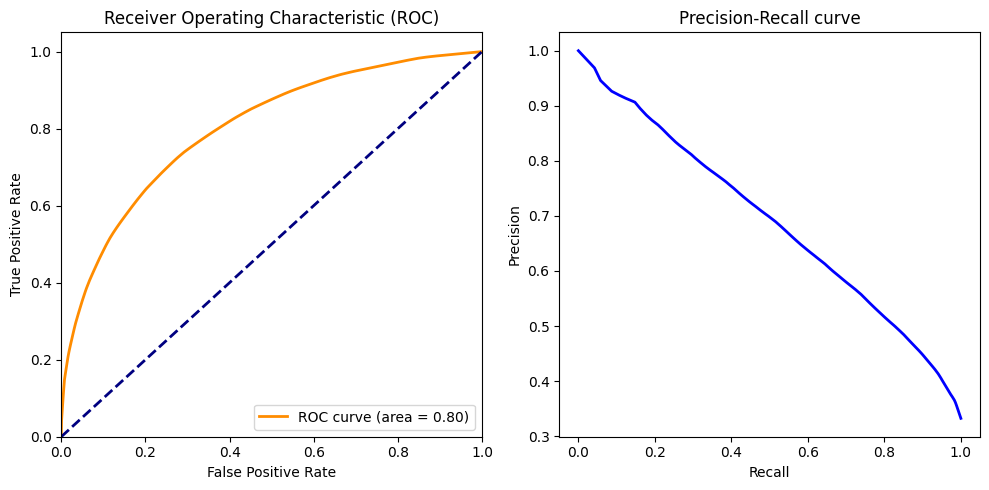

Average Decision Score: 0.33
Test Result:
Accuracy Score: 75.48%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.779393      0.677045  0.754774      0.728219      0.745577
recall         0.883981      0.492920  0.754774      0.688451      0.754774
f1-score       0.828399      0.570494  0.754774      0.699447      0.743187
support    29771.000000  14690.000000  0.754774  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[26317  3454]
 [ 7449  7241]]



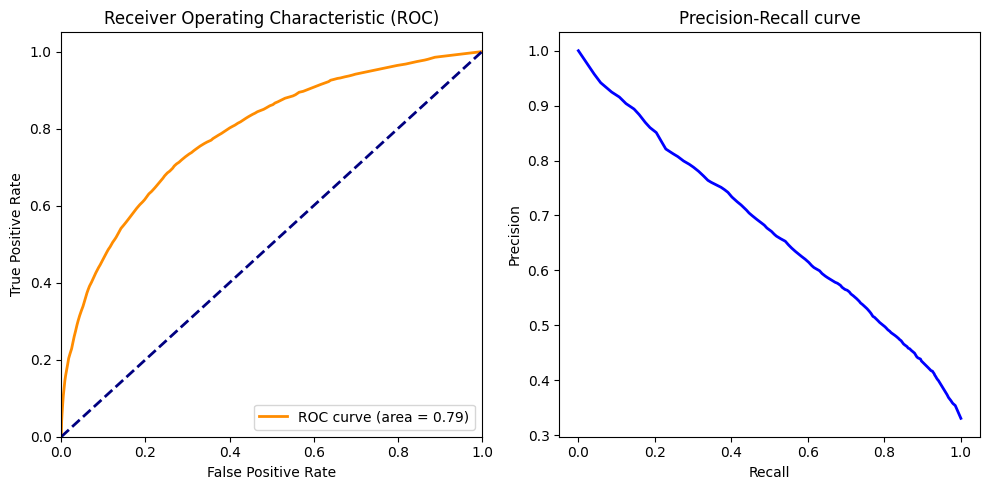

Average Decision Score: 0.33
Best params: OrderedDict([('max_depth', 8), ('max_features', 1.0), ('min_samples_leaf', 211)])


In [230]:
# #Evaluate the model
# y_train_pred = bayes_search_corr.predict(X_train_smote_corr)
# y_test_pred = bayes_search_corr.predict(X_test_gt_x2_corr)

# print_score(y_train_smote_corr, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)


# Step 5: Evaluate the model
y_train_pred_c_dt = bayes_search_corr.predict(X_train_s1_corr)
y_test_pred_c_dt = bayes_search_corr.predict(X_test_s1_corr)

# Get prediction probabilities
y_train_pred_proba_c_dt = bayes_search_corr.predict_proba(X_train_s1_corr)[:, 1]
y_test_pred_proba_c_dt = bayes_search_corr.predict_proba(X_test_s1_corr)[:, 1]

# Display results for the training set
print_score(y_train, y_train_pred_c_dt, y_train_pred_proba_c_dt, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_c_dt, y_test_pred_proba_c_dt, train=False)
# Extract best parameters
print("Best params:", bayes_search_corr.best_params_)


### DT No Smote

In [231]:
# Check DT model without using SMOTE
bayes_search_no_smote = BayesSearchCV(model_dt, params_dt, n_iter=20, cv=cv, verbose=3, random_state=SEED)
bayes_search_no_smote.fit(X_train_s1, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.781 total time=   0.5s
[CV 2/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.784 total time=   0.4s
[CV 3/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.784 total time=   0.4s
[CV 4/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.781 total time=   0.4s
[CV 5/5] END max_depth=8, max_features=0.8, min_samples_leaf=1866;, score=0.794 total time=   0.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.793 total time=   0.8s
[CV 2/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.797 total time=   0.8s
[CV 3/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.791 total time=   0.8s
[CV 4/5] END max_depth=13, max_features=1.0, min_samples_leaf=608;, score=0.789 total time

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=DecisionTreeClassifier(random_state=42), n_iter=20,
              random_state=42,
              search_spaces={'max_depth': Integer(low=3, high=15, prior='uniform', transform='normalize'),
                             'max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
                             'min_samples_leaf': Integer(low=1, high=2000, prior='uniform', transform='normalize')},
              verbose=3)

Train Result:
Accuracy Score: 80.24%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.811819      0.773754  0.802449      0.792786      0.799169
recall         0.916591      0.573122  0.802449      0.744856      0.802449
f1-score       0.861029      0.658495  0.802449      0.759762      0.793723
support    29661.000000  14763.000000  0.802449  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[27187  2474]
 [ 6302  8461]]



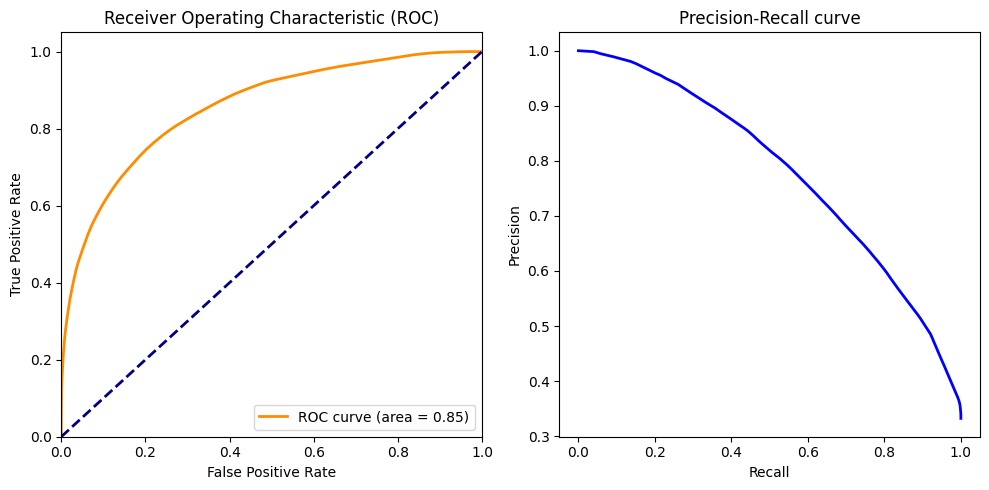

Average Decision Score: 0.33
Test Result:
Accuracy Score: 80.06%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.811146      0.767872  0.800567      0.789509      0.796848
recall         0.915253      0.568142  0.800567      0.741697      0.800567
f1-score       0.860060      0.653077  0.800567      0.756569      0.791673
support    29771.000000  14690.000000  0.800567  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[27248  2523]
 [ 6344  8346]]



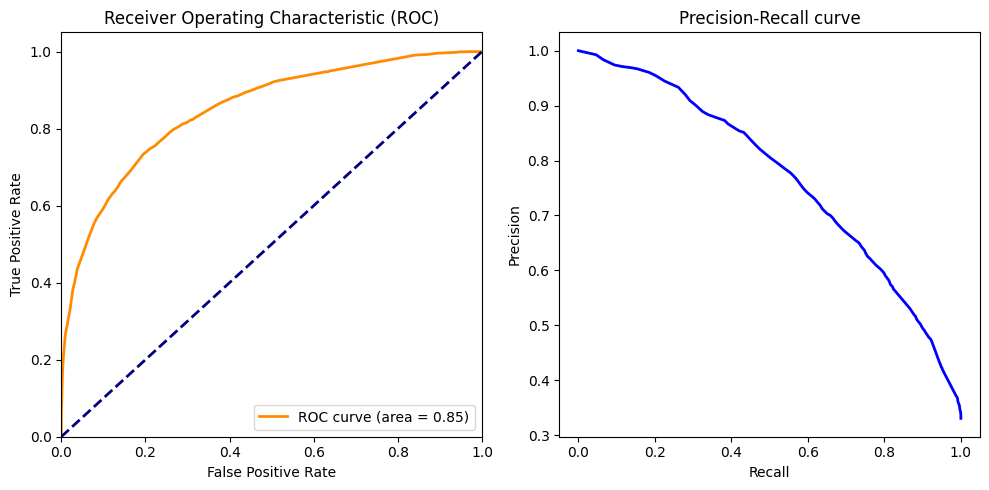

Average Decision Score: 0.33
Best params: OrderedDict([('max_depth', 8), ('max_features', 1.0), ('min_samples_leaf', 211)])


In [232]:
# Evaluate the model
# y_train_pred = bayes_search_no_smote.predict(X_train_gt_x2)
# y_test_pred = bayes_search_no_smote.predict(X_test_gt_x2)
# print_score(y_train, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_ns_dt = bayes_search_no_smote.predict(X_train_s1)
y_test_pred_ns_dt = bayes_search_no_smote.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_ns_dt = bayes_search_no_smote.predict_proba(X_train_s1)[:, 1]
y_test_pred_proba_ns_dt = bayes_search_no_smote.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train, y_train_pred_ns_dt, y_train_pred_proba_ns_dt, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_ns_dt, y_test_pred_proba_ns_dt, train=False)
# Extract best parameters
print("Best params:", bayes_search_no_smote.best_params_)


## DT Compare

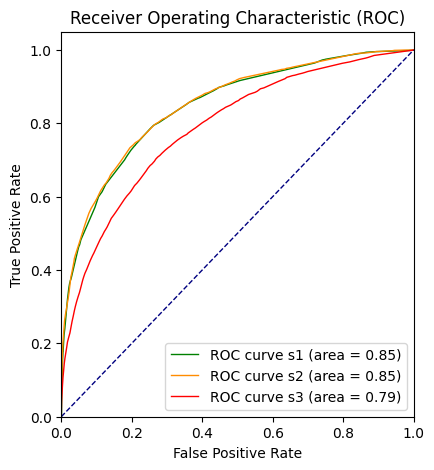

In [233]:
fpr1, tpr1, _ = roc_curve(y_test, y_test_pred_proba_s_dt)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_test_pred_proba_ns_dt)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_test_pred_proba_c_dt)
roc_auc3 = auc(fpr3, tpr3)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr1, tpr1, color='green', lw=1, label=f'ROC curve s1 (area = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label=f'ROC curve s2 (area = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='red', lw=1, label=f'ROC curve s3 (area = {roc_auc3:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Random Forest

In [234]:
# Step1: Define the model
# Instantiate a random forests regressor 'rf' 
model_rf = RandomForestClassifier(random_state= SEED)

In [235]:
# Step 2: Define param grid
param_grid_rf = {
    'n_estimators': Integer(30, 300),  
    'max_depth': Integer(2, 5),       
    'min_samples_leaf': [0.1, 0.2],   
    'max_features': ['log2', 'sqrt']   
}       

In [236]:
# Step 3: Tune hyperparameters
cv = StratifiedKFold(n_splits=5)
bayes_search = BayesSearchCV(model_rf, param_grid_rf, n_iter=20, cv=cv, verbose=3, random_state=SEED)

### RF Smote

In [237]:
# Step 4: Fit the model
bayes_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.684 total time=   2.6s
[CV 2/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.686 total time=   2.5s
[CV 3/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.689 total time=   2.6s
[CV 4/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.682 total time=   2.4s
[CV 5/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.691 total time=   2.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=0.1303410109884175, n_estimators=287;, score=0.698 total time=   8.4s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=0.1303410109884175, n_estima

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=RandomForestClassifier(random_state=42), n_iter=20,
              random_state=42,
              search_spaces={'max_depth': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'max_features': ['log2', 'sqrt'],
                             'min_samples_leaf': [0.1, 0.2],
                             'n_estimators': Integer(low=30, high=300, prior='uniform', transform='normalize')},
              verbose=3)

Train Result:
Accuracy Score: 71.44%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.690888      0.744578  0.714423      0.717733      0.717733
recall         0.776070      0.652776  0.714423      0.714423      0.714423
f1-score       0.731006      0.695662  0.714423      0.713334      0.713334
support    29661.000000  29661.000000  0.714423  59322.000000  59322.000000
_______________________________________________
Confusion Matrix: 
 [[23019  6642]
 [10299 19362]]



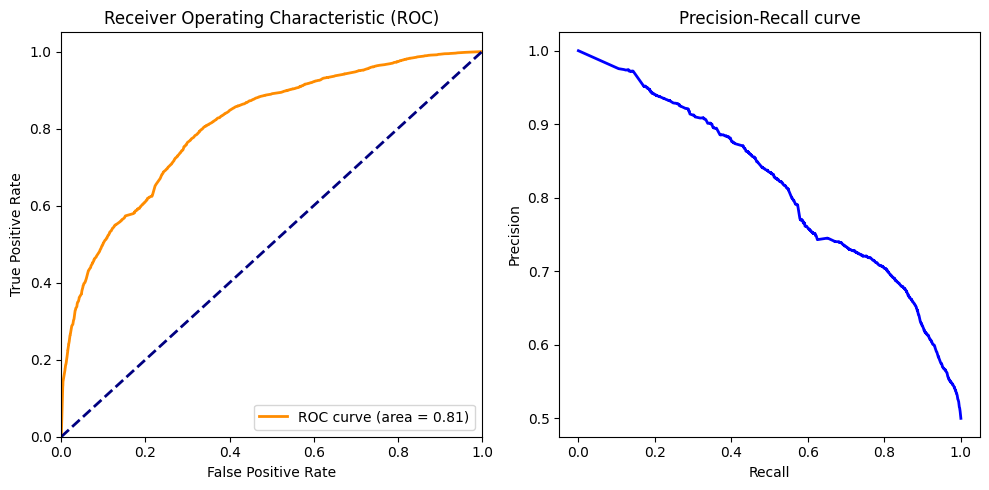

Average Decision Score: 0.50
Test Result:
Accuracy Score: 73.66%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.818300      0.592604  0.736623      0.705452      0.743730
recall         0.779819      0.649081  0.736623      0.714450      0.736623
f1-score       0.798597      0.619558  0.736623      0.709077      0.739442
support    29771.000000  14690.000000  0.736623  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[23216  6555]
 [ 5155  9535]]



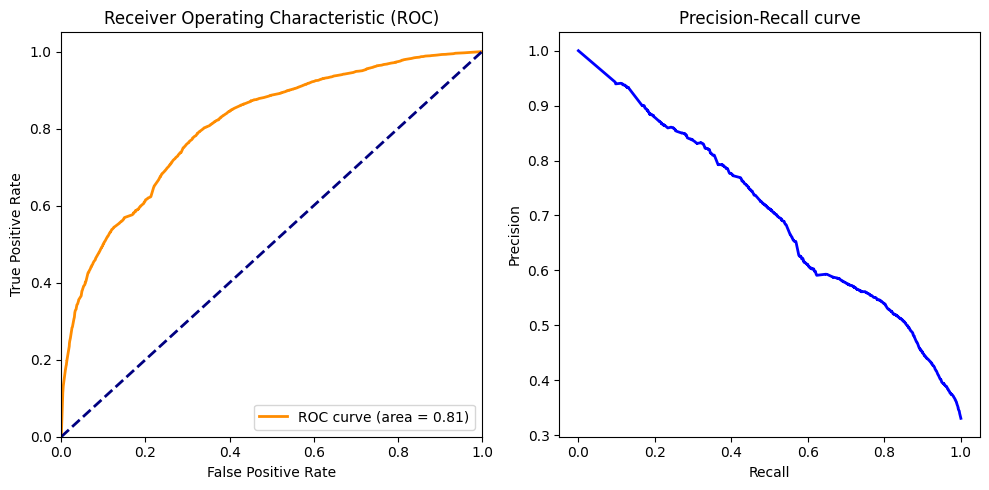

Average Decision Score: 0.46
Best params: OrderedDict([('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 0.1), ('n_estimators', 30)])


In [238]:
# # Step 5: Evaluate the Model
# y_train_pred = bayes_search.predict(X_train_smote)
# y_test_pred = bayes_search.predict(X_test_gt_x2)

# print_score(y_train_smote, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_s_rf = bayes_search.predict(X_train_smote)
y_test_pred_s_rf = bayes_search.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_s_rf = bayes_search.predict_proba(X_train_smote)[:, 1]
y_test_pred_proba_s_rf = bayes_search.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train_smote, y_train_pred_s_rf, y_train_pred_proba_s_rf, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_s_rf, y_test_pred_proba_s_rf, train=False)
# Extract best parameters
print("Best params:", bayes_search.best_params_)


### RF No Smote No Corr

In [239]:
# Check RF model after removing majority highly correlated variables - it gives only 7 variables

bayes_search_corr = BayesSearchCV(model_rf, param_grid_rf, n_iter=20, cv=cv, verbose=3, random_state=SEED)
bayes_search_corr.fit(X_train_s1_corr, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.684 total time=   0.9s
[CV 2/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.668 total time=   0.9s
[CV 3/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.668 total time=   0.9s
[CV 4/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.668 total time=   0.9s
[CV 5/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.668 total time=   0.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=0.1303410109884175, n_estimators=287;, score=0.699 total time=   3.0s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=0.1303410109884175, n_estima

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=RandomForestClassifier(random_state=42), n_iter=20,
              random_state=42,
              search_spaces={'max_depth': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'max_features': ['log2', 'sqrt'],
                             'min_samples_leaf': [0.1, 0.2],
                             'n_estimators': Integer(low=30, high=300, prior='uniform', transform='normalize')},
              verbose=3)

Train Result:
Accuracy Score: 73.29%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.735203      0.719636  0.732892      0.727420      0.730030
recall         0.937662      0.321479  0.732892      0.629571      0.732892
f1-score       0.824181      0.444424  0.732892      0.634302      0.697980
support    29661.000000  14763.000000  0.732892  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[27812  1849]
 [10017  4746]]



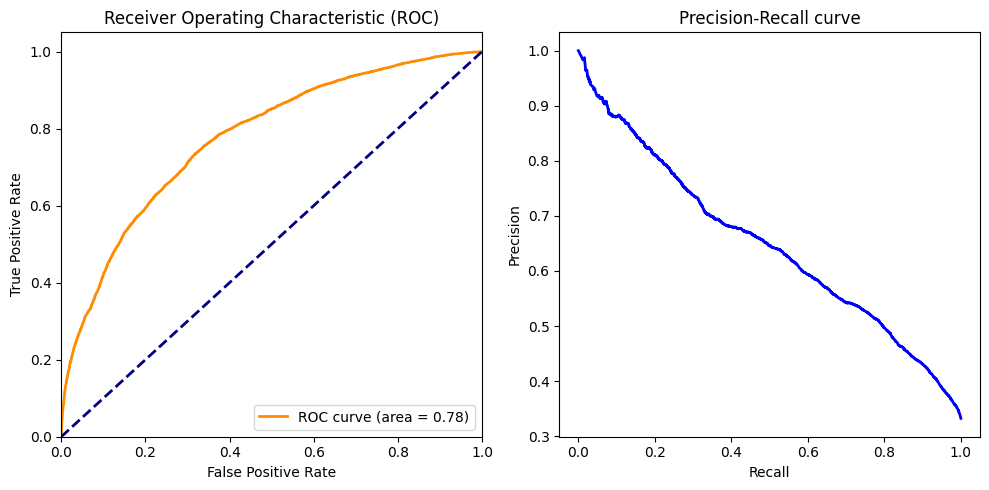

Average Decision Score: 0.33
Test Result:
Accuracy Score: 73.02%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.733206      0.711947  0.730168      0.722576      0.726182
recall         0.938531      0.307897  0.730168      0.623214      0.730168
f1-score       0.823259      0.429882  0.730168      0.626570      0.693286
support    29771.000000  14690.000000  0.730168  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[27941  1830]
 [10167  4523]]



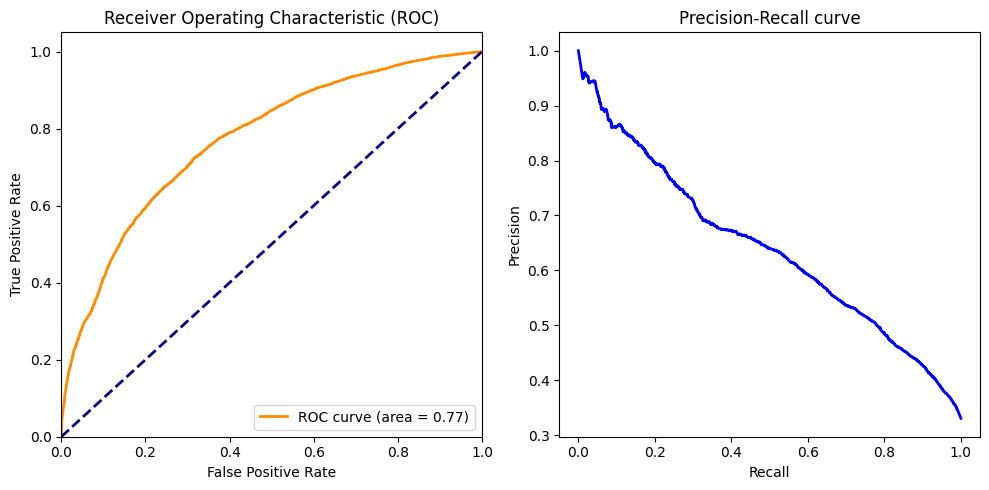

Average Decision Score: 0.33
Best params: OrderedDict([('max_depth', 5), ('max_features', 'log2'), ('min_samples_leaf', 0.10023062240423826), ('n_estimators', 165)])


In [240]:
# Evaluate the model after removing correlated variables 
# y_train_pred = bayes_search_corr.predict(X_train_smote_corr)
# y_test_pred = bayes_search_corr.predict(X_test_gt_x2_corr)

# print_score(y_train_smote_corr, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_c_rf = bayes_search_corr.predict(X_train_s1_corr)
y_test_pred_c_rf = bayes_search_corr.predict(X_test_s1_corr)

# Get prediction probabilities
y_train_pred_proba_c_rf = bayes_search_corr.predict_proba(X_train_s1_corr)[:, 1]
y_test_pred_proba_c_rf = bayes_search_corr.predict_proba(X_test_s1_corr)[:, 1]

# Display results for the training set
print_score(y_train, y_train_pred_c_rf, y_train_pred_proba_c_rf, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_c_rf, y_test_pred_proba_c_rf, train=False)
# Extract best parameters
print("Best params:", bayes_search_corr.best_params_)


### RF No Smote

In [241]:
# Check RF model without using SMOTE
bayes_search_no_smote = BayesSearchCV(model_rf, param_grid_rf, n_iter=20, cv=cv, verbose=3, random_state=SEED)
bayes_search_no_smote.fit(X_train_s1, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.724 total time=   1.8s
[CV 2/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.736 total time=   1.7s
[CV 3/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.727 total time=   1.8s
[CV 4/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.734 total time=   1.7s
[CV 5/5] END max_depth=3, max_features=sqrt, min_samples_leaf=0.1932867998847834, n_estimators=115;, score=0.739 total time=   1.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=0.1303410109884175, n_estimators=287;, score=0.740 total time=   4.8s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=0.1303410109884175, n_estima

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=RandomForestClassifier(random_state=42), n_iter=20,
              random_state=42,
              search_spaces={'max_depth': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'max_features': ['log2', 'sqrt'],
                             'min_samples_leaf': [0.1, 0.2],
                             'n_estimators': Integer(low=30, high=300, prior='uniform', transform='normalize')},
              verbose=3)

Train Result:
Accuracy Score: 76.74%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.781769      0.718559  0.767355      0.750164      0.760763
recall         0.903881      0.493057  0.767355      0.698469      0.767355
f1-score       0.838402      0.584823  0.767355      0.711613      0.754133
support    29661.000000  14763.000000  0.767355  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[26810  2851]
 [ 7484  7279]]



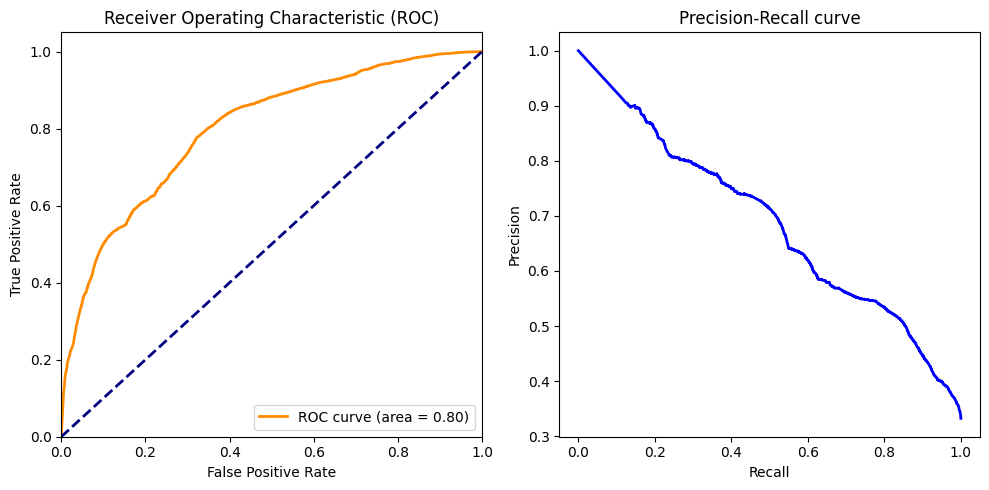

Average Decision Score: 0.33
Test Result:
Accuracy Score: 76.80%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.782682      0.717798  0.768021      0.750240      0.761244
recall         0.904773      0.490878  0.768021      0.697826      0.768021
f1-score       0.839311      0.583037  0.768021      0.711174      0.754637
support    29771.000000  14690.000000  0.768021  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[26936  2835]
 [ 7479  7211]]



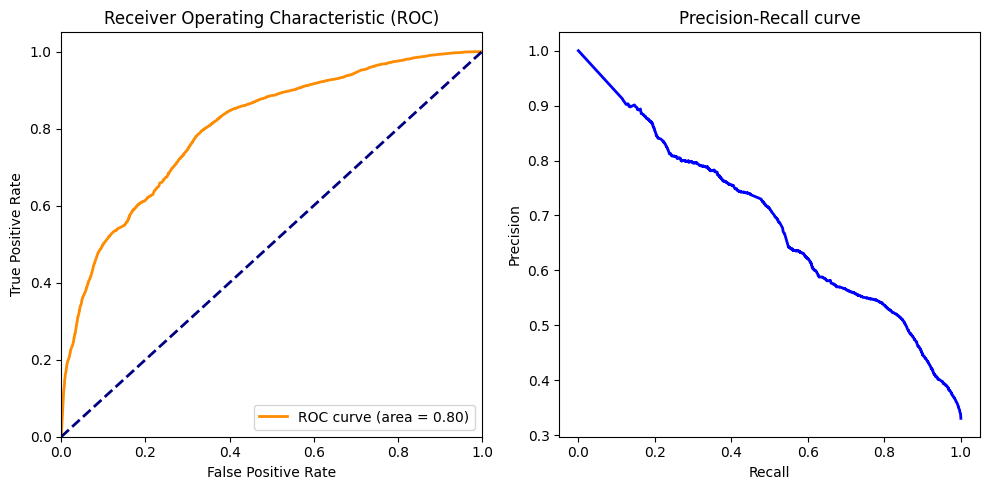

Average Decision Score: 0.33
Best params: OrderedDict([('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 0.1), ('n_estimators', 65)])


In [242]:
# Evaluate the model
# y_train_pred = bayes_search_no_smote.predict(X_train_gt_x2)
# y_test_pred = bayes_search_no_smote.predict(X_test_gt_x2)
# print_score(y_train, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_ns_rf = bayes_search_no_smote.predict(X_train_s1)
y_test_pred_ns_rf = bayes_search_no_smote.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_ns_rf = bayes_search_no_smote.predict_proba(X_train_s1)[:, 1]
y_test_pred_proba_ns_rf = bayes_search_no_smote.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train, y_train_pred_ns_rf, y_train_pred_proba_ns_rf, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_ns_rf, y_test_pred_proba_ns_rf, train=False)
# Extract best parameters
print("Best params:", bayes_search_no_smote.best_params_)


## RF Compare

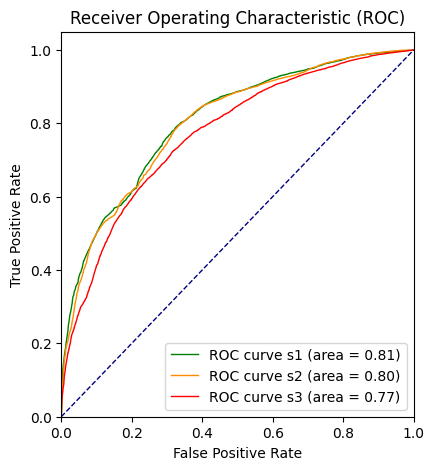

In [243]:
fpr1, tpr1, _ = roc_curve(y_test, y_test_pred_proba_s_rf)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_test_pred_proba_ns_rf)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_test_pred_proba_c_rf)
roc_auc3 = auc(fpr3, tpr3)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr1, tpr1, color='green', lw=1, label=f'ROC curve s1 (area = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label=f'ROC curve s2 (area = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='red', lw=1, label=f'ROC curve s3 (area = {roc_auc3:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# XGB

In [244]:
# Step1: Define the model
model_xgb = XGBClassifier(random_state= SEED)

In [245]:
param_grid_xgb = {
    'max_depth': Categorical([1, 2, 3]),
    'learning_rate': Categorical([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4]),
    'n_estimators': Categorical([10, 30, 50, 70])
}


In [246]:
# Step 3: Tune hyperparameters
cv = StratifiedKFold(n_splits=5)
bayes_search = BayesSearchCV(model_xgb, param_grid_xgb, n_iter=20, cv=cv, verbose=3, random_state=SEED)

### XGB Smote

In [247]:
# Step 4: Fit the model
bayes_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.759 total time=   1.7s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.768 total time=   1.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.797 total time=   1.9s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.818 total time=   2.5s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.828 total time=   1.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.758 total time=   1.2s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.769 total time=   1.1s
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.804 total time=   0.7s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.842 total time=   0.6s
[CV 5/5] END learning_rate=0.3,

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=42, ...),
              n_iter=20, random_state=42,
              search_spaces={'learning_rate': Categorical(categories=(0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4), prior=None),
                             'max_depth': Categorical(categories=(1, 2, 3), prior=None),
                             'n_estimators': Categorical(categories=(10, 30, 50, 70), prior=None)},
              verbose=3)

Train Result:
Accuracy Score: 83.45%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.815284      0.856240  0.834513      0.835762      0.835762
recall         0.865008      0.804019  0.834513      0.834513      0.834513
f1-score       0.839410      0.829308  0.834513      0.834359      0.834359
support    29661.000000  29661.000000  0.834513  59322.000000  59322.000000
_______________________________________________
Confusion Matrix: 
 [[25657  4004]
 [ 5813 23848]]



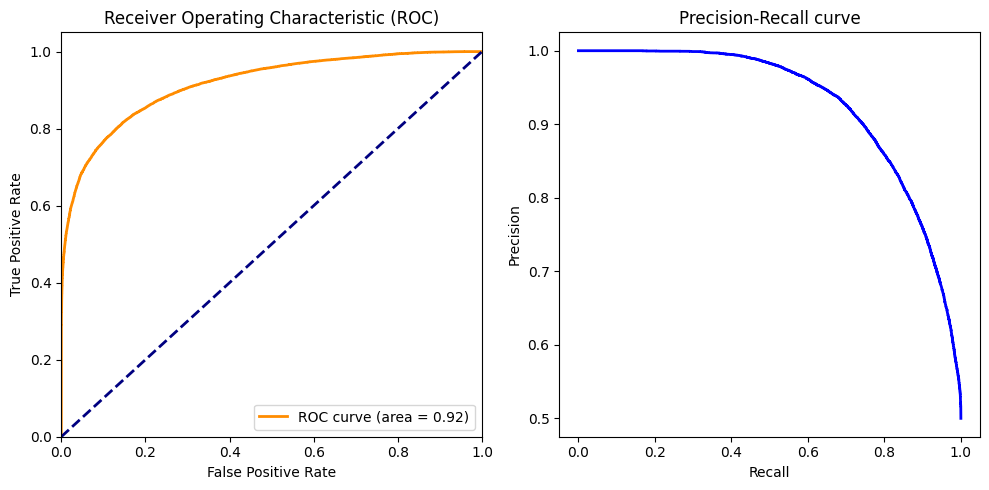

Average Decision Score: 0.50
Test Result:
Accuracy Score: 79.50%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.838507      0.699756  0.794966      0.769131      0.792663
recall         0.859293      0.664602  0.794966      0.761947      0.794966
f1-score       0.848772      0.681726  0.794966      0.765249      0.793580
support    29771.000000  14690.000000  0.794966  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[25582  4189]
 [ 4927  9763]]



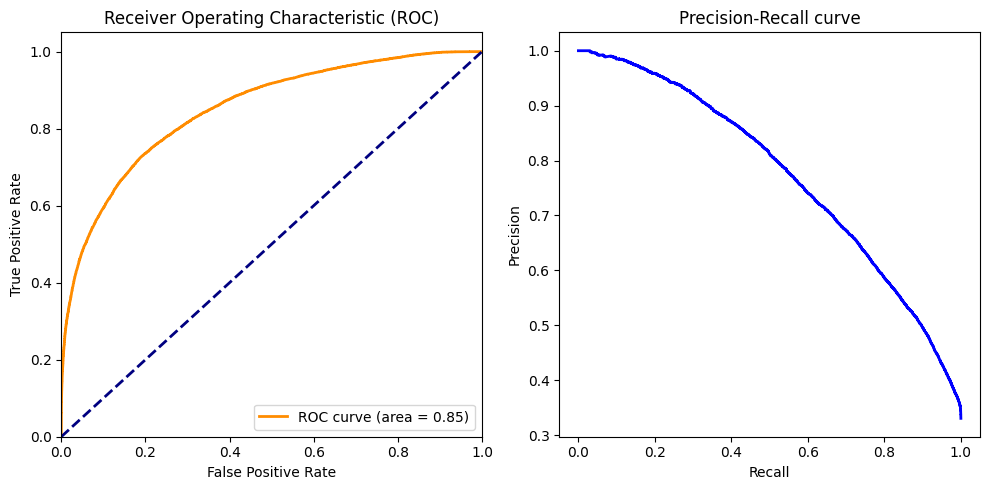

Average Decision Score: 0.37
Best params: OrderedDict([('learning_rate', 0.4), ('max_depth', 3), ('n_estimators', 70)])


In [248]:
# Step 5: Evaluate the model
# y_train_pred = bayes_search.predict(X_train_smote)
# y_test_pred = bayes_search.predict(X_test_gt_x2)

# print_score(y_train_smote, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_s_xgb = bayes_search.predict(X_train_smote)
y_test_pred_s_xgb = bayes_search.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_s_xgb = bayes_search.predict_proba(X_train_smote)[:, 1]
y_test_pred_proba_s_xgb = bayes_search.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train_smote, y_train_pred_s_xgb, y_train_pred_proba_s_xgb, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_s_xgb, y_test_pred_proba_s_xgb, train=False)

# Extract best parameters
print("Best params:", bayes_search.best_params_)

### XGB No Smote No Corr

In [249]:
# Check XGB model after removing majority highly correlated variables - it gives only 7 variables
bayes_search_corr = BayesSearchCV(model_xgb, param_grid_xgb, n_iter=20, cv=cv, verbose=3, random_state=SEED)
bayes_search_corr.fit(X_train_s1_corr, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.751 total time=   0.1s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.762 total time=   0.1s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.762 total time=   0.2s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.762 total time=   0.1s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.764 total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.756 total time=   0.1s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.767 total time=   0.1s
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.764 total time=   0.1s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.762 total time=   0.1s
[CV 5/5] END learning_rate=0.3,

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=42, ...),
              n_iter=20, random_state=42,
              search_spaces={'learning_rate': Categorical(categories=(0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4), prior=None),
                             'max_depth': Categorical(categories=(1, 2, 3), prior=None),
                             'n_estimators': Categorical(categories=(10, 30, 50, 70), prior=None)},
              verbose=3)

Train Result:
Accuracy Score: 77.40%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.790627      0.721451  0.774019      0.756039      0.767639
recall         0.899835      0.521236  0.774019      0.710535      0.774019
f1-score       0.841704      0.605215  0.774019      0.723459      0.763113
support    29661.000000  14763.000000  0.774019  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[26690  2971]
 [ 7068  7695]]



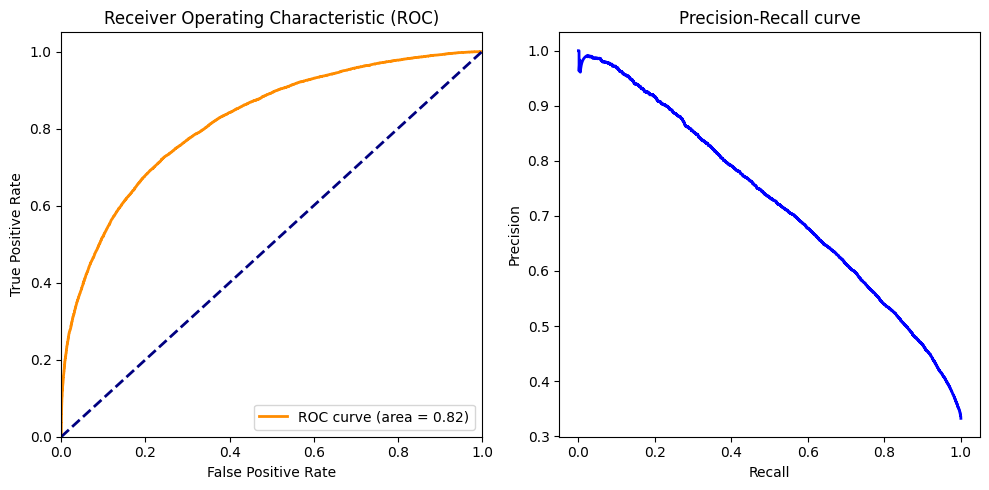

Average Decision Score: 0.33
Test Result:
Accuracy Score: 76.75%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.786261      0.707125  0.767549      0.746693      0.760114
recall         0.896577      0.506059  0.767549      0.701318      0.767549
f1-score       0.837803      0.589930  0.767549      0.713867      0.755906
support    29771.000000  14690.000000  0.767549  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[26692  3079]
 [ 7256  7434]]



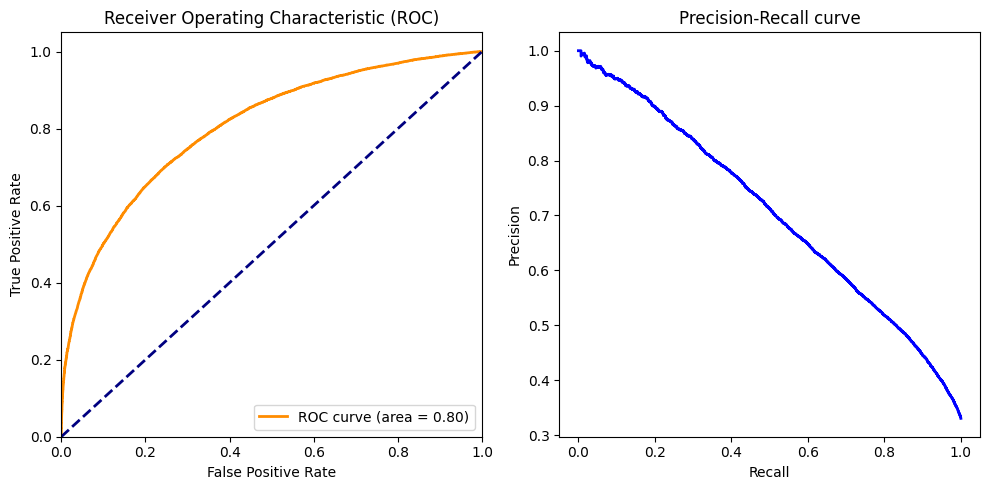

Average Decision Score: 0.33
Best params: OrderedDict([('learning_rate', 0.4), ('max_depth', 3), ('n_estimators', 70)])


In [250]:
# Evaluate the model after removing correlated variables 
# y_train_pred = bayes_search_corr.predict(X_train_smote_corr)
# y_test_pred = bayes_search_corr.predict(X_test_gt_x2_corr)

# print_score(y_train_smote_corr, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_c_xgb = bayes_search_corr.predict(X_train_s1_corr)
y_test_pred_c_xgb = bayes_search_corr.predict(X_test_s1_corr)

# Get prediction probabilities
y_train_pred_proba_c_xgb = bayes_search_corr.predict_proba(X_train_s1_corr)[:, 1]
y_test_pred_proba_c_xgb = bayes_search_corr.predict_proba(X_test_s1_corr)[:, 1]

# Display results for the training set
print_score(y_train, y_train_pred_c_xgb, y_train_pred_proba_c_xgb, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_c_xgb, y_test_pred_proba_c_xgb, train=False)

# Extract best parameters
print("Best params:", bayes_search_corr.best_params_)

### XGB No Smote

In [251]:
# Check XGB model without using SMOTE
bayes_search_no_smote = BayesSearchCV(model_xgb, param_grid_xgb, n_iter=20, cv=cv, verbose=3, random_state=SEED)
bayes_search_no_smote.fit(X_train_s1, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.799 total time=   0.8s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.804 total time=   0.6s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.797 total time=   0.6s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.798 total time=   0.6s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=70;, score=0.805 total time=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.799 total time=   0.3s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.804 total time=   0.3s
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.800 total time=   0.3s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=0.800 total time=   0.3s
[CV 5/5] END learning_rate=0.3,

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=42, ...),
              n_iter=20, random_state=42,
              search_spaces={'learning_rate': Categorical(categories=(0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4), prior=None),
                             'max_depth': Categorical(categories=(1, 2, 3), prior=None),
                             'n_estimators': Categorical(categories=(10, 30, 50, 70), prior=None)},
              verbose=3)

Train Result:
Accuracy Score: 80.76%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.821261      0.768632  0.807559      0.794947      0.803772
recall         0.909781      0.602181  0.807559      0.755981      0.807559
f1-score       0.863258      0.675301  0.807559      0.769279      0.800796
support    29661.000000  14763.000000  0.807559  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[26985  2676]
 [ 5873  8890]]



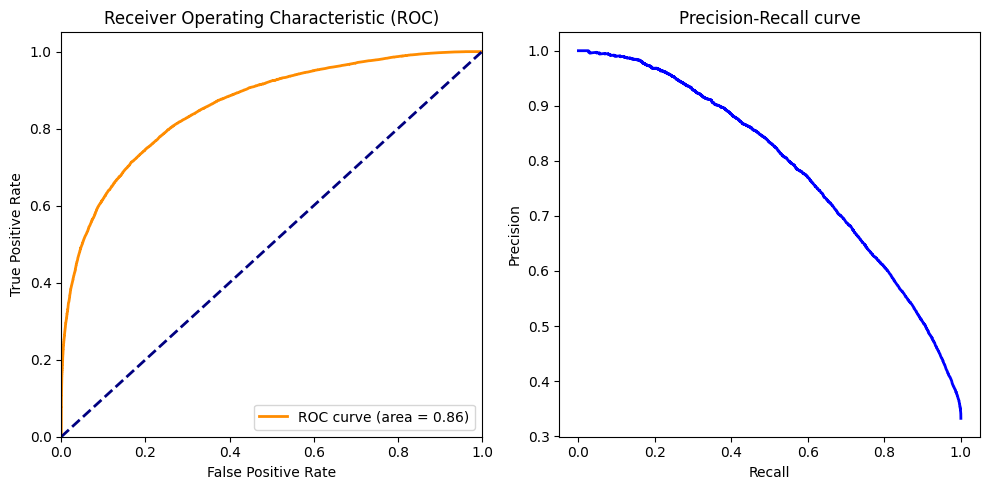

Average Decision Score: 0.33
Test Result:
Accuracy Score: 80.22%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.818508      0.755505  0.802164      0.787007      0.797692
recall         0.905277      0.593193  0.802164      0.749235      0.802164
f1-score       0.859708      0.664582  0.802164      0.762145      0.795238
support    29771.000000  14690.000000  0.802164  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[26951  2820]
 [ 5976  8714]]



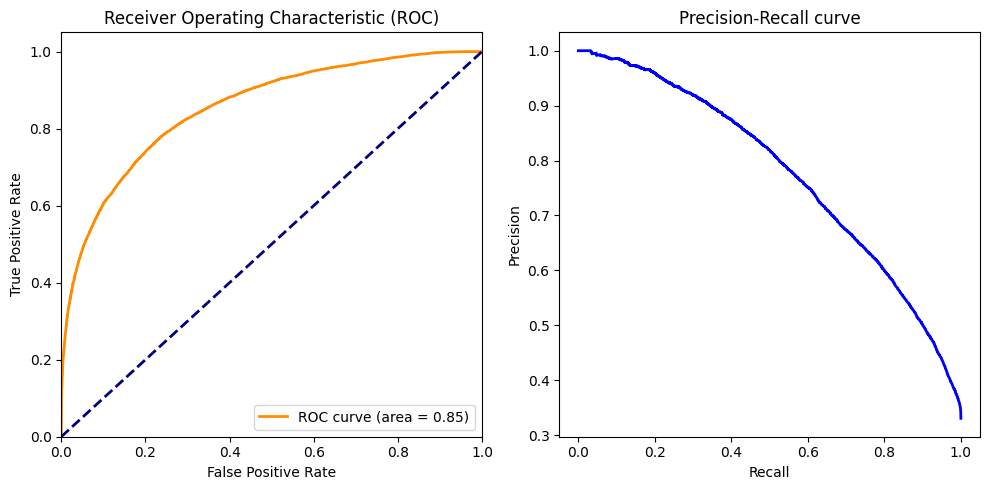

Average Decision Score: 0.33
Best params: OrderedDict([('learning_rate', 0.3), ('max_depth', 3), ('n_estimators', 30)])


In [252]:
# Evaluate the model
# y_train_pred = bayes_search_no_smote.predict(X_train_gt_x2)
# y_test_pred = bayes_search_no_smote.predict(X_test_gt_x2)
# print_score(y_train, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_ns_xgb = bayes_search_no_smote.predict(X_train_s1)
y_test_pred_ns_xgb = bayes_search_no_smote.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_ns_xgb = bayes_search_no_smote.predict_proba(X_train_s1)[:, 1]
y_test_pred_proba_ns_xgb = bayes_search_no_smote.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train, y_train_pred_ns_xgb, y_train_pred_proba_ns_xgb, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_ns_xgb, y_test_pred_proba_ns_xgb, train=False)

# Extract best parameters
print("Best params:", bayes_search_no_smote.best_params_)

## XGB Compare

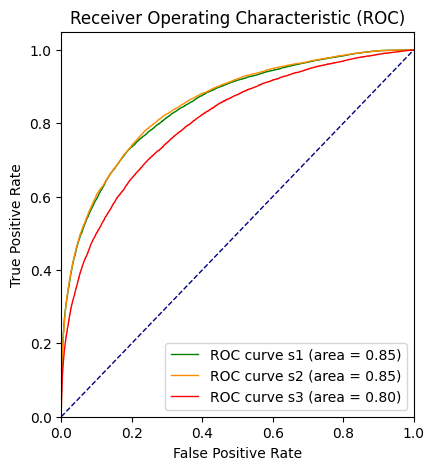

In [253]:
fpr1, tpr1, _ = roc_curve(y_test, y_test_pred_proba_s_xgb)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_test_pred_proba_ns_xgb)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_test_pred_proba_c_xgb)
roc_auc3 = auc(fpr3, tpr3)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr1, tpr1, color='green', lw=1, label=f'ROC curve s1 (area = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label=f'ROC curve s2 (area = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='red', lw=1, label=f'ROC curve s3 (area = {roc_auc3:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# KNN

In [254]:
error_rate = []
# Will take some time
for i in range(1,60):
 
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train_smote, y_train_smote)
 pred_i = knn.predict(X_test_s1)
 error_rate.append(np.mean(pred_i != y_test))

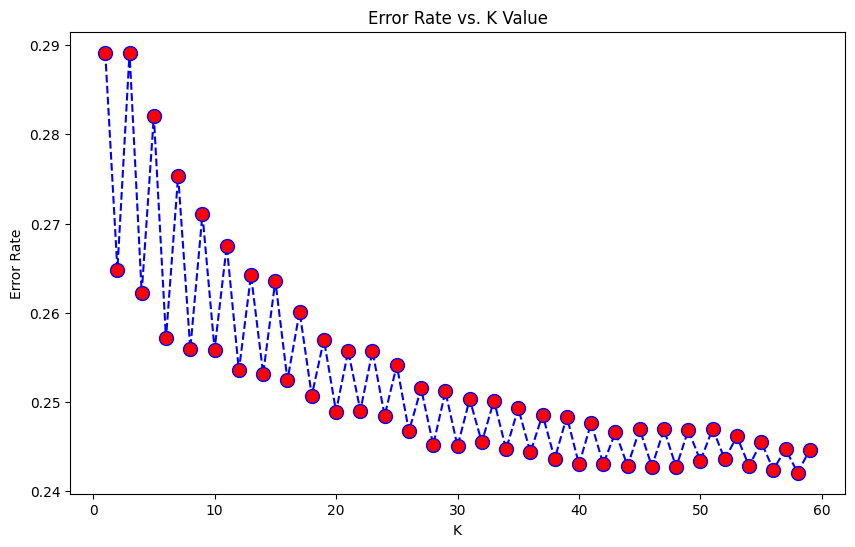

In [255]:
plt.figure(figsize=(10,6))
plt.plot(range(1,60), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

In [256]:
# Step 1: Define the model
model_knn = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [22],   
    'metric': Categorical(['minkowski', 'euclidean', 'manhattan'])
    }

In [257]:
# Step 3: Tune hyperparameters
cv = StratifiedKFold(n_splits=5)
bayes_search = BayesSearchCV(model_knn, param_grid_knn, n_iter=20, cv=cv, verbose=3, random_state=SEED)


### KNN Smote

In [258]:
# Step 4: Fit the model
bayes_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..metric=euclidean, n_neighbors=22;, score=0.749 total time=   4.1s
[CV 2/5] END ..metric=euclidean, n_neighbors=22;, score=0.767 total time=   4.5s
[CV 3/5] END ..metric=euclidean, n_neighbors=22;, score=0.767 total time=   4.0s
[CV 4/5] END ..metric=euclidean, n_neighbors=22;, score=0.768 total time=   4.4s
[CV 5/5] END ..metric=euclidean, n_neighbors=22;, score=0.779 total time=   4.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..metric=manhattan, n_neighbors=22;, score=0.749 total time=  19.0s
[CV 2/5] END ..metric=manhattan, n_neighbors=22;, score=0.767 total time=  18.2s
[CV 3/5] END ..metric=manhattan, n_neighbors=22;, score=0.770 total time=  17.7s
[CV 4/5] END ..metric=manhattan, n_neighbors=22;, score=0.766 total time=  18.0s
[CV 5/5] END ..metric=manhattan, n_neighbors=22;, score=0.777 total time=  19.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=KNeighborsClassifier(), n_iter=20, random_state=42,
              search_spaces={'metric': Categorical(categories=('minkowski', 'euclidean', 'manhattan'), prior=None),
                             'n_neighbors': [22]},
              verbose=3)

Train Result:
Accuracy Score: 79.10%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.795010      0.787140  0.791022      0.791075      0.791075
recall         0.784262      0.797782  0.791022      0.791022      0.791022
f1-score       0.789600      0.792425  0.791022      0.791012      0.791012
support    29661.000000  29661.000000  0.791022  59322.000000  59322.000000
_______________________________________________
Confusion Matrix: 
 [[23262  6399]
 [ 5998 23663]]



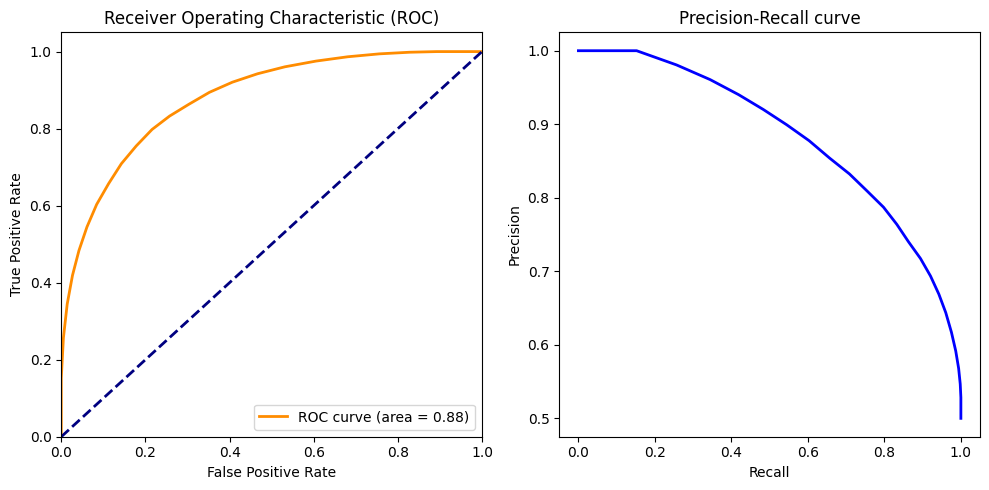

Average Decision Score: 0.52
Test Result:
Accuracy Score: 75.10%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.847449      0.603065  0.750973      0.725257      0.766704
recall         0.765980      0.720558  0.750973      0.743269      0.750973
f1-score       0.804658      0.656597  0.750973      0.730627      0.755738
support    29771.000000  14690.000000  0.750973  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[22804  6967]
 [ 4105 10585]]



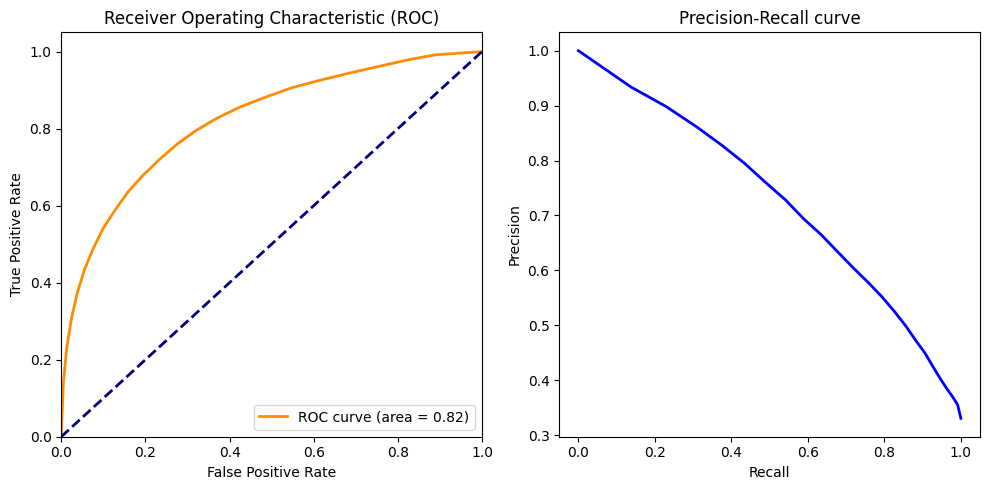

Average Decision Score: 0.44
Best params: OrderedDict([('metric', 'euclidean'), ('n_neighbors', 22)])


In [259]:
# Step 3: Evaluate the model
# y_train_pred = bayes_search.predict(X_train_smote)
# y_test_pred = bayes_search.predict(X_test_gt_x2)

# print_score(y_train_smote, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_s_kn = bayes_search.predict(X_train_smote)
y_test_pred_s_kn = bayes_search.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_s_kn = bayes_search.predict_proba(X_train_smote)[:, 1]
y_test_pred_proba_s_kn = bayes_search.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train_smote, y_train_pred_s_kn, y_train_pred_proba_s_kn, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_s_kn, y_test_pred_proba_s_kn, train=False)

# Extract best parameters
print("Best params:", bayes_search.best_params_)

### KNN No Smote No Corr

In [260]:
# Check KNN model after removing majority highly correlated variables - it gives only 7 variables
bayes_search_corr = BayesSearchCV(model_knn, param_grid_knn, n_iter=20, cv=cv, verbose=3, random_state=SEED)
bayes_search_corr.fit(X_train_s1_corr, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..metric=euclidean, n_neighbors=22;, score=0.746 total time=   0.7s
[CV 2/5] END ..metric=euclidean, n_neighbors=22;, score=0.756 total time=   0.5s
[CV 3/5] END ..metric=euclidean, n_neighbors=22;, score=0.757 total time=   0.5s
[CV 4/5] END ..metric=euclidean, n_neighbors=22;, score=0.760 total time=   0.5s
[CV 5/5] END ..metric=euclidean, n_neighbors=22;, score=0.760 total time=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..metric=manhattan, n_neighbors=22;, score=0.748 total time=   0.8s
[CV 2/5] END ..metric=manhattan, n_neighbors=22;, score=0.758 total time=   0.7s
[CV 3/5] END ..metric=manhattan, n_neighbors=22;, score=0.759 total time=   0.7s
[CV 4/5] END ..metric=manhattan, n_neighbors=22;, score=0.756 total time=   0.7s
[CV 5/5] END ..metric=manhattan, n_neighbors=22;, score=0.761 total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=KNeighborsClassifier(), n_iter=20, random_state=42,
              search_spaces={'metric': Categorical(categories=('minkowski', 'euclidean', 'manhattan'), prior=None),
                             'n_neighbors': [22]},
              verbose=3)

Train Result:
Accuracy Score: 77.51%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.781608      0.751369  0.775144      0.766488      0.771559
recall         0.920401      0.483303  0.775144      0.701852      0.775144
f1-score       0.845345      0.588235  0.775144      0.716790      0.759902
support    29661.000000  14763.000000  0.775144  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[27300  2361]
 [ 7628  7135]]



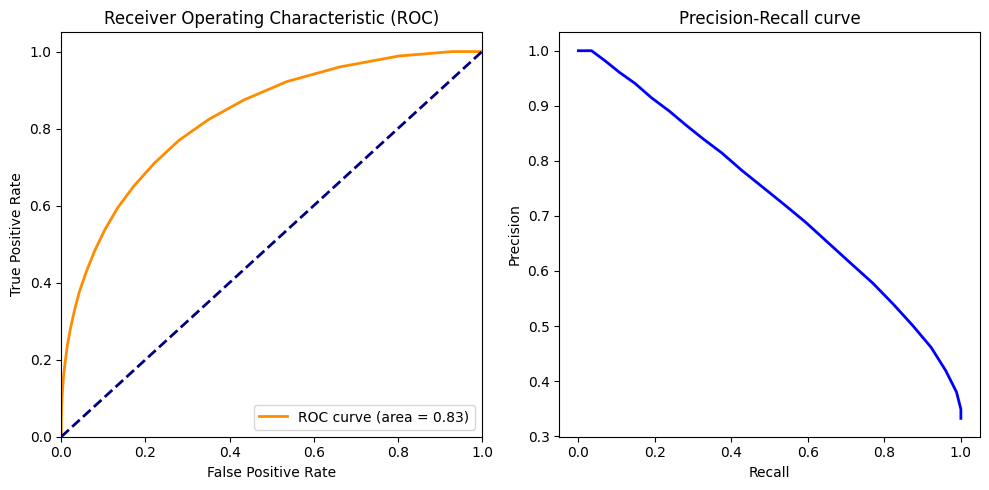

Average Decision Score: 0.32
Test Result:
Accuracy Score: 75.91%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.770539      0.715430  0.759092      0.742985      0.752331
recall         0.911726      0.449762  0.759092      0.680744      0.759092
f1-score       0.835208      0.552309  0.759092      0.693759      0.741738
support    29771.000000  14690.000000  0.759092  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[27143  2628]
 [ 8083  6607]]



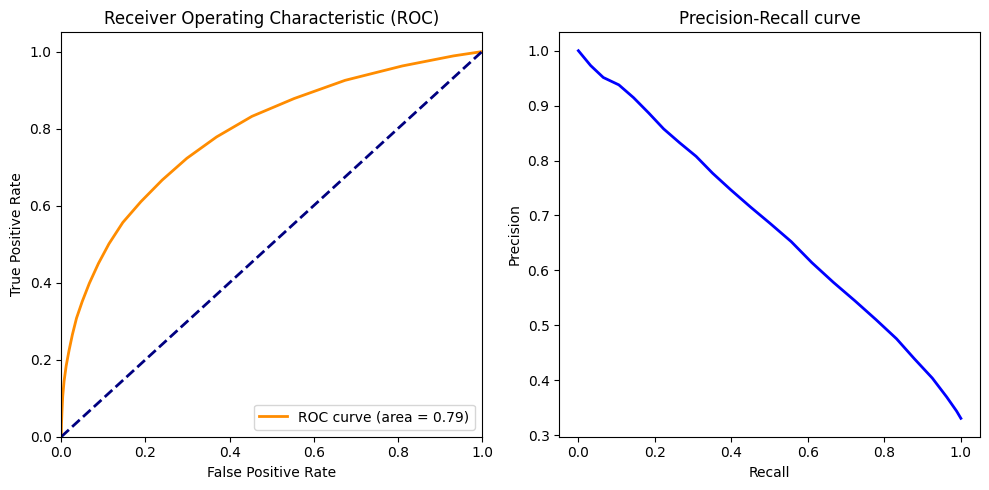

Average Decision Score: 0.32
Best params: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 22)])


In [261]:
# Evaluate the model after removing correlated variables 
# y_train_pred = bayes_search_corr.predict(X_train_smote_corr)
# y_test_pred = bayes_search_corr.predict(X_test_gt_x2_corr)

# print_score(y_train_smote_corr, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_c_kn = bayes_search_corr.predict(X_train_s1_corr)
y_test_pred_c_kn = bayes_search_corr.predict(X_test_s1_corr)

# Get prediction probabilities
y_train_pred_proba_c_kn = bayes_search_corr.predict_proba(X_train_s1_corr)[:, 1]
y_test_pred_proba_c_kn = bayes_search_corr.predict_proba(X_test_s1_corr)[:, 1]

# Display results for the training set
print_score(y_train, y_train_pred_c_kn, y_train_pred_proba_c_kn, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_c_kn, y_test_pred_proba_c_kn, train=False)

# Extract best parameters
print("Best params:", bayes_search_corr.best_params_)

### KNN No Smote

In [262]:
# Check KNN model without using SMOTE
bayes_search_no_smote = BayesSearchCV(model_knn, param_grid_knn, n_iter=20, cv=cv, verbose=3, random_state=SEED)
bayes_search_no_smote.fit(X_train_s1, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..metric=euclidean, n_neighbors=22;, score=0.779 total time=   2.5s
[CV 2/5] END ..metric=euclidean, n_neighbors=22;, score=0.784 total time=   2.7s
[CV 3/5] END ..metric=euclidean, n_neighbors=22;, score=0.785 total time=   3.1s
[CV 4/5] END ..metric=euclidean, n_neighbors=22;, score=0.785 total time=   3.2s
[CV 5/5] END ..metric=euclidean, n_neighbors=22;, score=0.789 total time=   2.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..metric=manhattan, n_neighbors=22;, score=0.774 total time=  22.6s
[CV 2/5] END ..metric=manhattan, n_neighbors=22;, score=0.783 total time=  12.2s
[CV 3/5] END ..metric=manhattan, n_neighbors=22;, score=0.781 total time=  17.6s
[CV 4/5] END ..metric=manhattan, n_neighbors=22;, score=0.782 total time=  12.1s
[CV 5/5] END ..metric=manhattan, n_neighbors=22;, score=0.784 total time=  11.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=KNeighborsClassifier(), n_iter=20, random_state=42,
              search_spaces={'metric': Categorical(categories=('minkowski', 'euclidean', 'manhattan'), prior=None),
                             'n_neighbors': [22]},
              verbose=3)

Train Result:
Accuracy Score: 79.95%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.803913      0.784749  0.799478      0.794331      0.797544
recall         0.925390      0.546501  0.799478      0.735946      0.799478
f1-score       0.860385      0.644306  0.799478      0.752345      0.788578
support    29661.000000  14763.000000  0.799478  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[27448  2213]
 [ 6695  8068]]



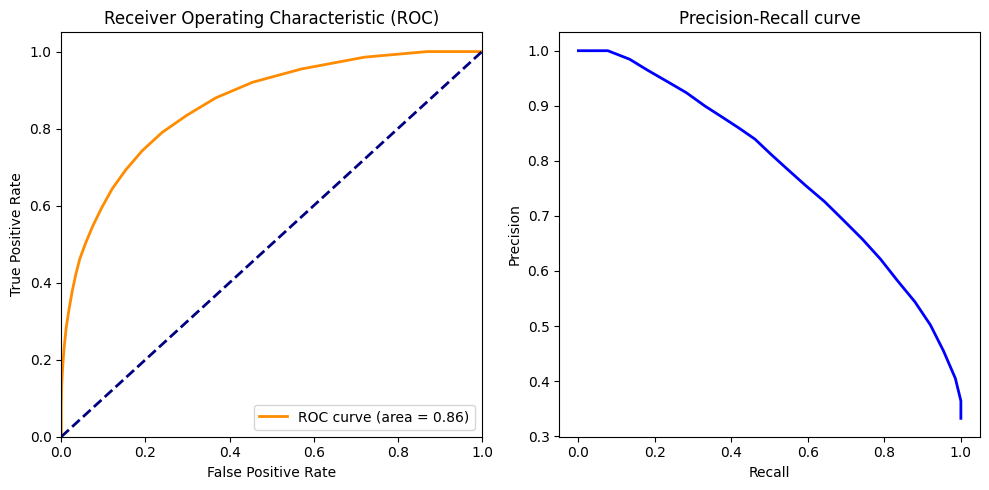

Average Decision Score: 0.32
Test Result:
Accuracy Score: 78.62%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.796067      0.753371   0.78624      0.774719      0.781960
recall         0.915220      0.524847   0.78624      0.720033      0.786240
f1-score       0.851495      0.618681   0.78624      0.735088      0.774573
support    29771.000000  14690.000000   0.78624  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[27247  2524]
 [ 6980  7710]]



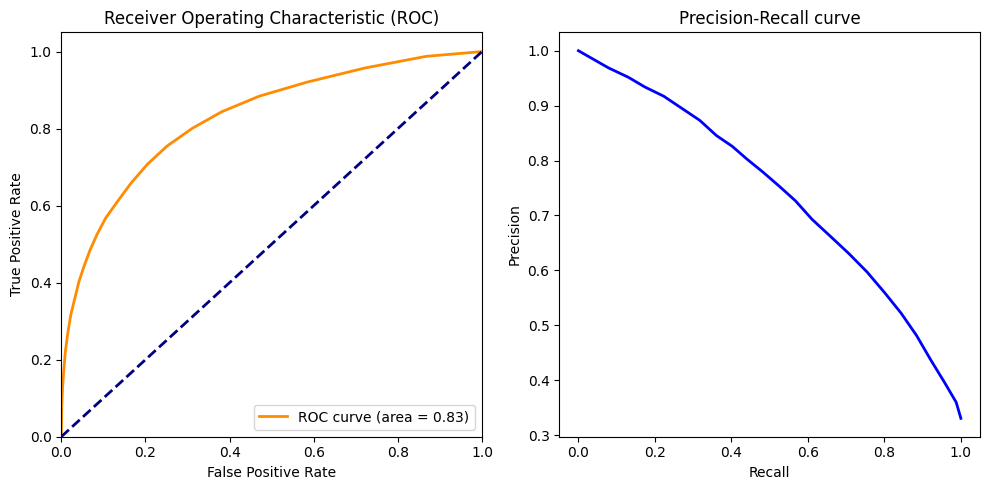

Average Decision Score: 0.32
Best params: OrderedDict([('metric', 'euclidean'), ('n_neighbors', 22)])


In [263]:
# Evaluate the model
# y_train_pred = bayes_search_no_smote.predict(X_train_gt_x2)
# y_test_pred = bayes_search_no_smote.predict(X_test_gt_x2)
# print_score(y_train, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

# Step 5: Evaluate the model
y_train_pred_ns_kn = bayes_search_no_smote.predict(X_train_s1)
y_test_pred_ns_kn = bayes_search_no_smote.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_ns_kn = bayes_search_no_smote.predict_proba(X_train_s1)[:, 1]
y_test_pred_proba_ns_kn = bayes_search_no_smote.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train, y_train_pred_ns_kn, y_train_pred_proba_ns_kn, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_ns_kn, y_test_pred_proba_ns_kn, train=False)

# Extract best parameters
print("Best params:", bayes_search_no_smote.best_params_)

### KNN Compare

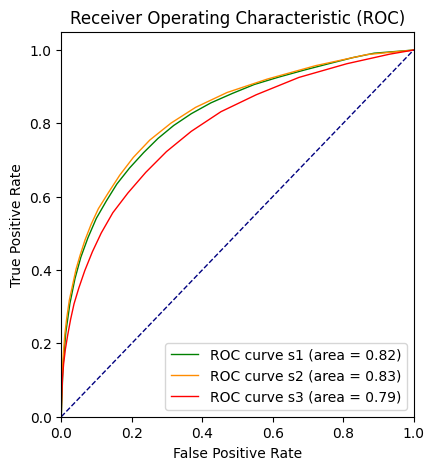

In [264]:
fpr1, tpr1, _ = roc_curve(y_test, y_test_pred_proba_s_kn)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_test_pred_proba_ns_kn)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_test_pred_proba_c_kn)
roc_auc3 = auc(fpr3, tpr3)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr1, tpr1, color='green', lw=1, label=f'ROC curve s1 (area = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label=f'ROC curve s2 (area = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='red', lw=1, label=f'ROC curve s3 (area = {roc_auc3:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Neural Networks

In [265]:
# Load the dataset [SMOTE]

# Convert to numpy arrays where needed
X_train_s1 = X_train_s1.values
X_test_s1 = X_test_s1.values
X_train_s1_corr = X_train_s1_corr.values
X_test_s1_corr = X_test_s1_corr.values
X_train_smote = X_train_smote.values
y_train = y_train.values
y_test = y_test.values
y_train_smote = y_train_smote.values

# Ensure y is a 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()
y_train_smote = y_train_smote.ravel()



AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
np.random.seed(42)
def get_model(optimizer="adam", activation="relu", nl=1, nn=165):
    # Create a Sequential model
    model = Sequential()
    # Add an input layer and a hidden layer with nn neurons for hidden layer
    model.add(Dense(nn, input_shape=(165,), activation=activation))
    for i in range(nl):
        model.add(Dense(nn, activation="relu"))
    # Add a 1-neuron output layer; always sigmoid
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # Summarise your model
    model.summary()
    return model

model = KerasClassifier(build_fn=get_model, verbose=0)

# Define a callback to monitor val_accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# Save the best model as best_model.keras
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max')

params = {
    'model__optimizer': Categorical(['sgd', 'adam']),
    'model__nl': Integer(1, 3),
    'model__nn': Integer(1, 165),
    'batch_size': Integer(32, 256),
    'epochs': Integer(2, 20)
}

bayes_search = BayesSearchCV(model, params, n_iter=20, cv=5, n_jobs=-1)

### NN with Smote

In [ ]:
bayes_search_results = bayes_search.fit(X_train_smote, y_train_smote, validation_data=(X_test_s1, y_test), callbacks=[monitor_val_acc, model_checkpoint])

# Evaluate your model
print("Best: %f using %s" % (bayes_search_results.best_score_, bayes_search_results.best_params_))

# Extract best parameters
best_params = bayes_search_results.best_params_

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 53)             │         8,798 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │         2,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 53)             │         2,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 53)             │         2,862 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_4 (Dense)                 │ (None, 1)              │            54 │
└─────────────────────────────────┴───────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 157)            │        26,062 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 157)            │        24,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 157)            │        24,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           158 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 75,832 (296.22 KB)
 Trainable params: 75,832 (296.22 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_1"
┏

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 157)            │        26,062 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 157)            │        24,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 157)            │        24,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           158 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 75,832 (296.22 KB)
 Trainable params: 75,832 (296.22 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential"
Model

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model

Model: "sequential_1"
Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 72)             │        11,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 72)             │         5,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)               

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_2"
Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 133)            │        22,078 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 133)            │        17,822 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 133)            │        17,822 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           134 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 57,856 (226.00 KB)
 Trainable params: 57,856 (226.00 KB)
 Non-trainable params: 0 (0.00 B)
┏

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_3"
Model: "sequential_3"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 118)            │        19,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 118)            │        14,042 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 118)            │        14,042 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_4"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 32)             │         5,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 6,401 (25.00 KB)
 Trainable params: 6,401 (25.00 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_5"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 144)            │        23,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 144)            │        20,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 144)            │        20,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           145 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 65,809 (257.07 KB)
 Trainable params: 65,809 (257.07 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_4"
M

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_5"
Model: "sequential_5"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 138)            │        22,908 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 138)            │        19,182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 138)            │        19,182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           139 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 61,411 (239.89 KB)
 Trainable params: 61,411 (239.89 KB)
 Non-trainable params: 0 (0.00 B)
┏

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_6"
Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 69)             │        11,454 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 69)             │         4,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 69)             │         4,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 69)             │         4,830 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_27 (Dense)                │ (None, 1)              │            70 │
└─────────────────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_7"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 43)             │         7,138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 43)             │         1,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 43)             │         1,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 10,966 (42.84 KB)
 Trainable params: 10,966 (42.84 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_6"
┏━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_7"
Model: "sequential_5"
Model: "sequential_5"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 164)            │        27,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 164)            │        27,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 164)            │        27,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 81,509 (318.39 KB)
 Trainable params: 81,509 (318.39 KB)
 Non-trainabl

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_8"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 2)              │           332 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 347 (1.36 KB)
 Trainable params: 347 (1.36 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_6"
┏━━━━━━━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_4"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 121)            │        20,086 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 121)            │        14,762 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 121)            │        14,762 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 121)            │        14,762 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_21 (Dense)                │ (None, 1)              │           122 │
└─────────────────────────────────┴─────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model

Model: "sequential_10"
Model: "sequential_8"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           166 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 54,946 (214.63 KB)
 Trainable params: 54,946 (214.63 KB)
 Non-trainable params: 0 (0.00 B)
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_9"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_39 (Dense)                │ (None, 1)              │           166 │
└─────────────────────────────────┴─────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_6"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 80)             │        13,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_31 (Dense)                │ (None, 1)              │            81 │
└─────────────────────────────────┴─────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_10"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_45 (Dense)                │ (None, 1)              │           166 │
└─────────────────────────────────┴────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_12"
Model: "sequential_12"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 1)              │           166 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_54 (Dense)                │ (None, 1)              │             2 │
└───────────────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`

Model: "sequential_13"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 52)             │         8,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 52)             │         2,756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            53 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 11,441 (44.69 KB)
 Trainable params: 11,441 (44.69 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_13"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_9"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 33)             │         5,478 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 33)             │         1,122 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 33)             │         1,122 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 33)             │         1,122 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_44 (Dense)                │ (None, 1)              │            34 │
└─────────────────────────────────┴─────────────────

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 157)            │        26,062 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 157)            │        24,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 157)            │        24,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,832 (296.22 KB)

 Trainable params: 75,832 (296.22 KB)

 Non-trainable params: 0 (0.00 B)

Best: 0.776390 using OrderedDict([('batch_size', 220), ('epochs', 18), ('model__nl', 2), ('model__nn', 157), ('model__optimizer', 'adam')])


Train Result:
Accuracy Score: 81.20%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.813991      0.810119  0.812043      0.812055      0.812055
recall         0.808941      0.815144  0.812043      0.812043      0.812043
f1-score       0.811458      0.812624  0.812043      0.812041      0.812041
support    29661.000000  29661.000000  0.812043  59322.000000  59322.000000
_______________________________________________
Confusion Matrix: 
 [[23994  5667]
 [ 5483 24178]]



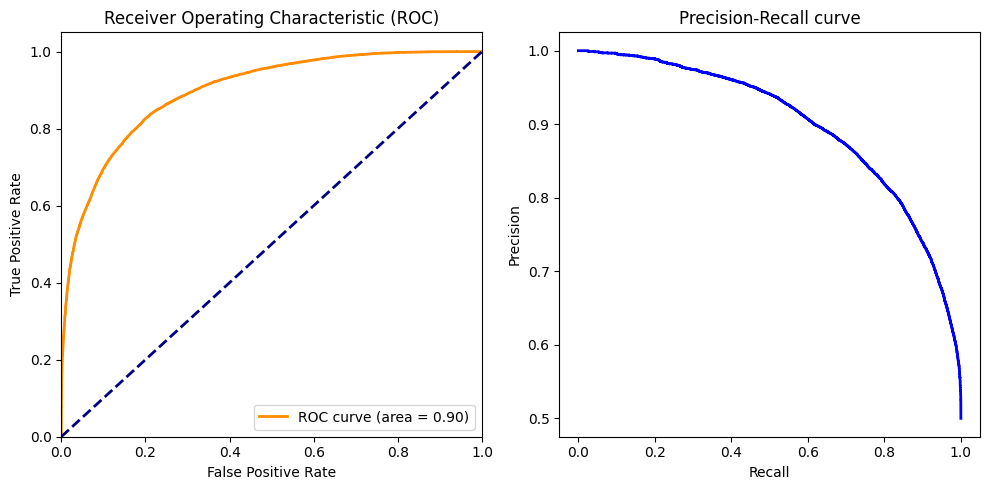

Average Decision Score: 0.49
Test Result:
Accuracy Score: 76.18%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.851777      0.619200  0.761814      0.735489      0.774933
recall         0.780021      0.724915  0.761814      0.752468      0.761814
f1-score       0.814321      0.667900  0.761814      0.741111      0.765943
support    29771.000000  14690.000000  0.761814  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[23222  6549]
 [ 4041 10649]]



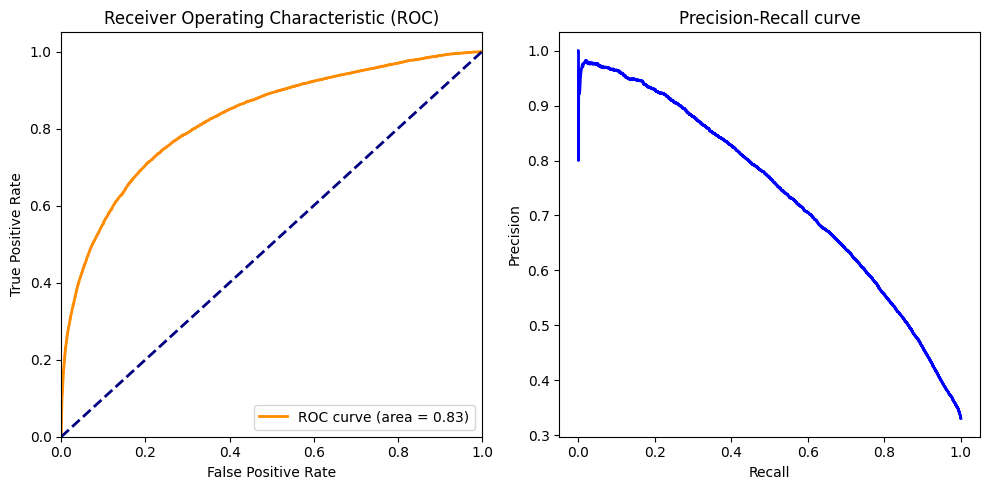

Average Decision Score: 0.41


In [ ]:
# Step 5: Evaluate the model
y_train_pred_s_nn = bayes_search_results.predict(X_train_smote)
y_test_pred_s_nn = bayes_search_results.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_s_nn = bayes_search_results.predict_proba(X_train_smote)[:, 1]
y_test_pred_proba_s_nn = bayes_search_results.predict_proba(X_test_s1)[:, 1]

# Display results for the training set
print_score(y_train_smote, y_train_pred_s_nn, y_train_pred_proba_s_nn, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_s_nn, y_test_pred_proba_s_nn, train=False)


### NN No Smote

In [ ]:
bayes_search_no_smote = bayes_search.fit(X_train_s1, y_train, validation_data=(X_test_s1, y_test), callbacks=[monitor_val_acc, model_checkpoint])

# Evaluate your model
print("Best: %f using %s" % (bayes_search_no_smote.best_score_, bayes_search_no_smote.best_params_))

# Extract best parameters
best_params = bayes_search_no_smote.best_params_

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`

Model: "sequential_15"
Model: "sequential_15"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 96)             │        15,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
Model: "sequential_12"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Lay

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_13"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 21)             │         3,486 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 3,970 (15.51 KB)
 Trainable params: 3,970 (15.51 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_10"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_17"
Model: "sequential_11"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 126)            │        20,916 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 126)            │        16,002 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 126)            │        16,002 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │           127 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 53,047 (207.21 KB)
 Trainable params: 53,047 (207.21 KB)
 Non-trainable params: 0 (0.00 B)

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_17"
Model: "sequential_18"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 126)            │        20,916 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 126)            │        16,002 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 126)            │        16,002 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │           127 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 53,047 (207.21 KB)
 Trainable params: 53,047 (207.21 KB)
 Non-trainable params: 0 (0.00 B)

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_15"
Model: "sequential_12"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                │ (None, 6)              │           996 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 1,087 (4.25 KB)
 Trainable params: 1,087 (4.25 KB)
 Non-trainable params: 0 (0.00 B)
┏━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_15"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                │ (None, 45)             │         7,470 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 45)             │         2,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 9,586 (37.45 KB)
 Trainable params: 9,586 (37.45 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_13"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_14"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 6)              │           996 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 1,087 (4.25 KB)
 Trainable params: 1,087 (4.25 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_16"
┏━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_15"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_58 (Dense)                │ (None, 8)              │         1,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 1,481 (5.79 KB)
 Trainable params: 1,481 (5.79 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_17"
┏━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_18"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 131)            │        21,746 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 131)            │        17,292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 131)            │        17,292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 56,462 (220.55 KB)
 Trainable params: 56,462 (220.55 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_16"

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_19"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 103)            │        17,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 103)            │        10,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 27,914 (109.04 KB)
 Trainable params: 27,914 (109.04 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_20"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_15"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 161)            │        26,726 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 161)            │        26,082 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │           162 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 52,970 (206.91 KB)
 Trainable params: 52,970 (206.91 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_18"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_22"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                │ (None, 69)             │        11,454 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 69)             │         4,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            70 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 16,354 (63.88 KB)
 Trainable params: 16,354 (63.88 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_19"
Model: "sequential_16"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape         

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_19"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 159)            │        26,394 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 159)            │        25,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 159)            │        25,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 159)            │        25,440 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_82 (Dense)                │ (None, 1)              │           160 │
└─────────────────────────────────┴────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_20"
Model: "sequential_20"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 149)            │        24,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 149)            │        22,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │           150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 47,234 (184.51 KB)
 Trainable params: 47,234 (184.51 KB)
 Non-trainable params: 0 (0.00 B)
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_19"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 21)             │         3,486 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_81 (Dense)                │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_21"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 165)            │        27,390 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_89 (Dense)                │ (None, 1)              │           166 │
└─────────────────────────────────┴────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_22"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 6)              │           996 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_94 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_23"
Model: "sequential_24"
Model: "sequential_23"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 148)            │        24,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 148)            │        22,052 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 148)            │        22,052 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 148)            │        22,052 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_94 (Dense)                │ (None, 1)              │           149 │
└────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_25"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_104 (Dense)               │ (None, 75)             │        12,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 75)             │         5,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 18,226 (71.20 KB)
 Trainable params: 18,226 (71.20 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_24"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_25"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 113)            │        18,758 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 113)            │        12,882 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 1)              │           114 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 31,754 (124.04 KB)
 Trainable params: 31,754 (124.04 KB)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_22"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 6)              │           996 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,129 (4.41 KB)

 Trainable params: 1,129 (4.41 KB)

 Non-trainable params: 0 (0.00 B)

Best: 0.797452 using OrderedDict([('batch_size', 36), ('epochs', 12), ('model__nl', 3), ('model__nn', 6), ('model__optimizer', 'adam')])


Train Result:
Accuracy Score: 80.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.819188      0.747265   0.79995      0.783226      0.795286
recall         0.898756      0.601436   0.79995      0.750096      0.799950
f1-score       0.857129      0.666467   0.79995      0.761798      0.793768
support    29661.000000  14763.000000   0.79995  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[26658  3003]
 [ 5884  8879]]



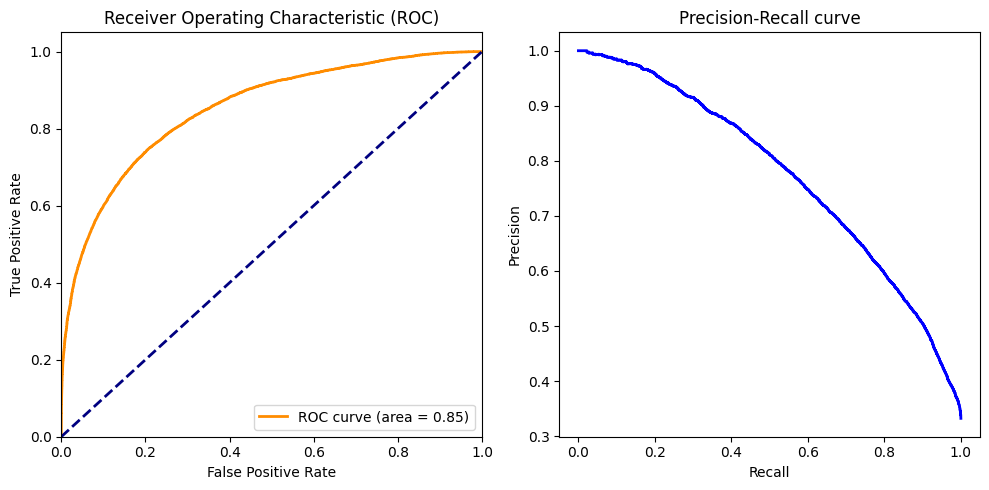

Average Decision Score: 0.35
Test Result:
Accuracy Score: 79.53%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.816705      0.736406  0.795349      0.776556      0.790174
recall         0.895301      0.592784  0.795349      0.744043      0.795349
f1-score       0.854199      0.656836  0.795349      0.755517      0.788990
support    29771.000000  14690.000000  0.795349  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[26654  3117]
 [ 5982  8708]]



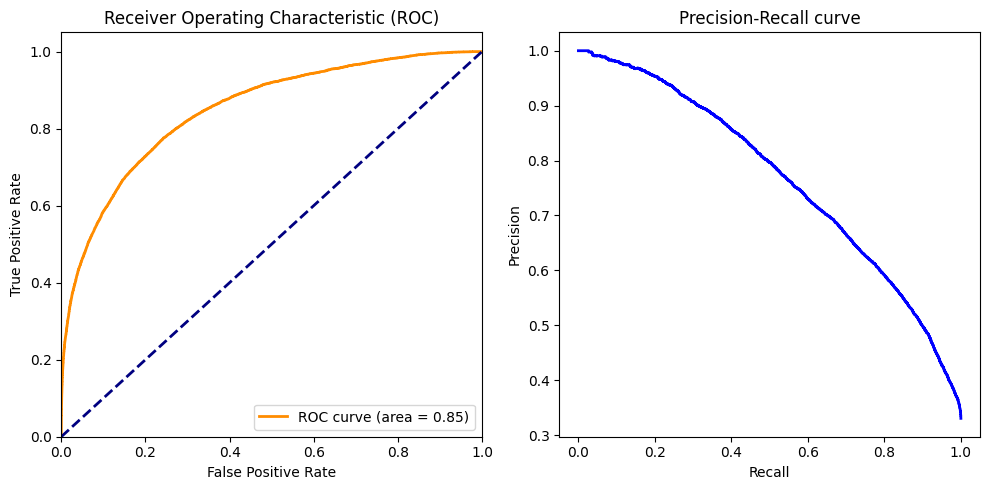

Average Decision Score: 0.35


In [ ]:
# Step 5: Evaluate the model
y_train_pred_ns_nn = bayes_search_no_smote.predict(X_train_s1)
y_test_pred_ns_nn = bayes_search_no_smote.predict(X_test_s1)

# Get prediction probabilities
y_train_pred_proba_ns_nn = bayes_search_no_smote.predict_proba(X_train_s1)[:, 1]
y_test_pred_proba_ns_nn = bayes_search_no_smote.predict_proba(X_test_s1)[:, 1]

# Display results for the train set
print_score(y_train, y_train_pred_ns_nn, y_train_pred_proba_ns_nn, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_ns_nn, y_test_pred_proba_ns_nn, train=False)

### No Corr no Smote, new model defined to have correct nn=8

In [ ]:
np.random.seed(42)
def get_model(optimizer="adam", activation="relu", nl=1, nn=8):
    # Create a Sequential model
    model = Sequential()
    # Add an input layer and a hidden layer with nn neurons for hidden layer
    model.add(Dense(nn, input_shape=(8,), activation=activation))
    for i in range(nl):
        model.add(Dense(nn, activation="relu"))
    # Add a 1-neuron output layer; always sigmoid
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # Summarise your model
    model.summary()
    return model

model = KerasClassifier(build_fn=get_model, verbose=0)

# Define a callback to monitor val_accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# Save the best model as best_model.keras
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max')

params = {
    'model__optimizer': Categorical(['sgd', 'adam']),
    'model__nl': Integer(1, 3),
    'model__nn': Integer(1, 8),
    'batch_size': Integer(32, 256),
    'epochs': Integer(2, 20)
}

bayes_search = BayesSearchCV(model, params, n_iter=20, cv=5, n_jobs=-1)

In [ ]:
bayes_search_corr = bayes_search.fit(X_train_s1_corr, y_train, validation_data=(X_test_s1_corr, y_test), callbacks=[monitor_val_acc, model_checkpoint])

# Evaluate your model
print("Best: %f using %s" % (bayes_search_corr.best_score_, bayes_search_corr.best_params_))

# Extract best parameters
best_params = bayes_search_corr.best_params_

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`

Model: "sequential_24"
Model: "sequential_26"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_95 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_99 (Dense)                │ (None, 1)              │             4 │
└───────────────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_27"
Model: "sequential_29"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 225 (900.00 B)
 Trainable params: 225 (900.00 B)
 Non-trainable params: 0 (0.00 B)
┏━━━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_28"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_116 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 61 (244.00 B)
 Trainable params: 61 (244.00 B)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_24"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_26"
Model: "sequential_29"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_119 (Dense)               │ (None, 7)              │            63 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 183 (732.00 B)
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_27"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_110 (Dense)               │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 145 (580.00 B)
 Trainable params: 145 (580.00 B)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_26"
┏━━━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_27"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_110 (Dense)               │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 27 (108.00 B)
 Trainable params: 27 (108.00 B)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_29"
Model: "sequential_30"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃     

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_28"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)               │ (None, 7)              │            63 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 183 (732.00 B)
 Trainable params: 183 (732.00 B)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_30"
Model: 

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_33"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)               │ (None, 7)              │            63 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 183 (732.00 B)
 Trainable params: 183 (732.00 B)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_29"
Model: 

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_29"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_118 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_122 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_30"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 55 (220.00 B)
 Trainable params: 55 (220.00 B)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_27"
┏━━━━━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_31"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_127 (Dense)               │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_131 (Dense)               │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_35"
Model: "sequential_28"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 225 (900.00 B)
 Trainable params: 225 (900.00 B)
 Non-trainable params: 0 (0.00 B)
┏━━━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_36"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_146 (Dense)               │ (None, 1)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 15 (60.00 B)
 Trainable params: 15 (60.00 B)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_33"
┏━━━━━━━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`

Model: "sequential_34"
Model: "sequential_34"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_144 (Dense)               │ (None, 1)              │             9 │
└───────────────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_33"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 153 (612.00 B)
 Trainable params: 153 (612.00 B)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_35"
Model: "sequential_32"
Model: "sequential_31"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Outp

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_153 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_157 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`

Model: "sequential_32"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_130 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_134 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_36"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_150 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 153 (612.00 B)
 Trainable params: 153 (612.00 B)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_33"
Model: "sequential_36"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃   

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_37"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_150 (Dense)               │ (None, 1)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────���───┘
 Total params: 15 (60.00 B)
 Trainable params: 15 (60.00 B)
 Non-trainable params: 0 (0.00 B)
Model: "sequential_33"
┏━━━━━━━━━━

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_37"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_148 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_152 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────

/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/ewelinakowalewska/Desktop/credit_scoring/venv/lib/python3.11

Model: "sequential_38"
Model: "sequential_38"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_153 (Dense)               │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────���───┤
│ dense_157 (Dense)               │ (None, 1)              │             6 │
└───────────────────────────

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

Best: 0.757924 using OrderedDict([('batch_size', 256), ('epochs', 20), ('model__nl', 3), ('model__nn', 8), ('model__optimizer', 'adam')])


Train Result:
Accuracy Score: 76.22%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.782068      0.698506  0.762178      0.740287      0.754299
recall         0.892519      0.500305  0.762178      0.696412      0.762178
f1-score       0.833651      0.583021  0.762178      0.708336      0.750361
support    29661.000000  14763.000000  0.762178  44424.000000  44424.000000
_______________________________________________
Confusion Matrix: 
 [[26473  3188]
 [ 7377  7386]]



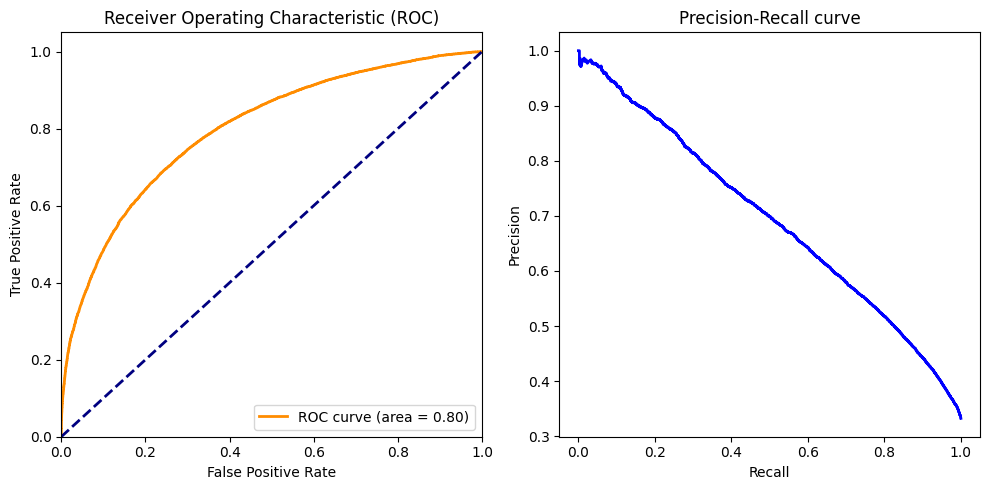

Average Decision Score: 0.34
Test Result:
Accuracy Score: 76.11%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.782126      0.693273  0.761094      0.737699      0.752768
recall         0.891572      0.496664  0.761094      0.694118      0.761094
f1-score       0.833271      0.578726  0.761094      0.705998      0.749169
support    29771.000000  14690.000000  0.761094  44461.000000  44461.000000
_______________________________________________
Confusion Matrix: 
 [[26543  3228]
 [ 7394  7296]]



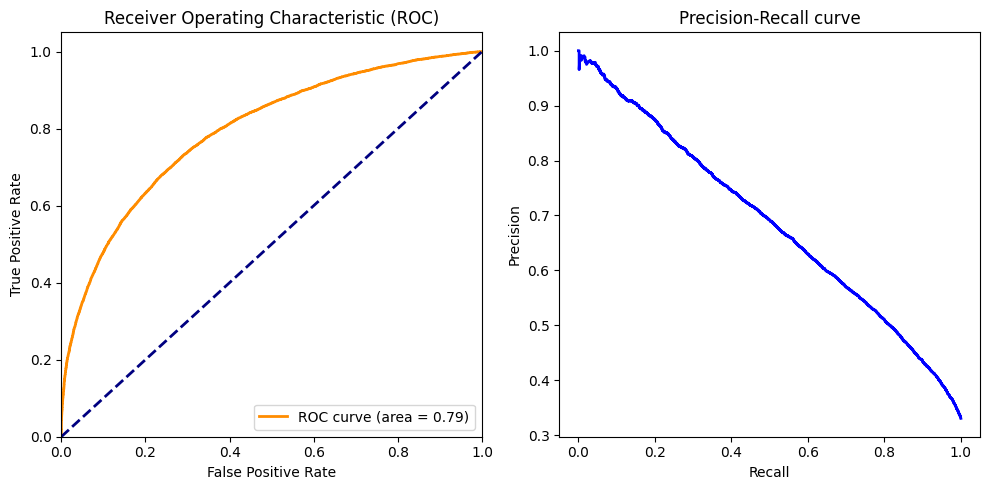

Average Decision Score: 0.34


In [ ]:
# Step 5: Evaluate the model
y_train_pred_c_nn = bayes_search_corr.predict(X_train_s1_corr)
y_test_pred_c_nn = bayes_search_corr.predict(X_test_s1_corr)

# Get prediction probabilities
y_train_pred_proba_c_nn = bayes_search_corr.predict_proba(X_train_s1_corr)[:, 1]
y_test_pred_proba_c_nn = bayes_search_corr.predict_proba(X_test_s1_corr)[:, 1]

# Display results for the train set
print_score(y_train, y_train_pred_c_nn, y_train_pred_proba_c_nn, train=True)

# Display results for the test set
print_score(y_test, y_test_pred_c_nn, y_test_pred_proba_c_nn, train=False)

## NN Compare

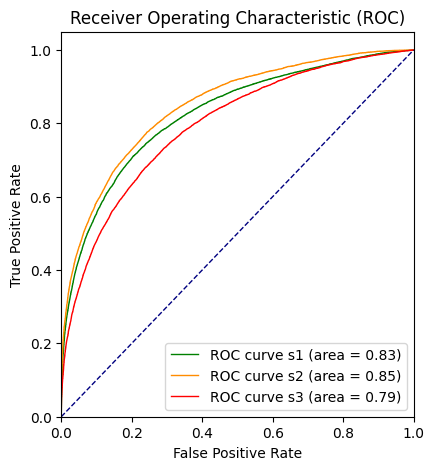

In [ ]:
fpr1, tpr1, _ = roc_curve(y_test, y_test_pred_proba_s_nn)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_test_pred_proba_ns_nn)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_test_pred_proba_c_nn)
roc_auc3 = auc(fpr3, tpr3)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr1, tpr1, color='green', lw=1, label=f'ROC curve s1 (area = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label=f'ROC curve s2 (area = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='red', lw=1, label=f'ROC curve s3 (area = {roc_auc3:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Compare models

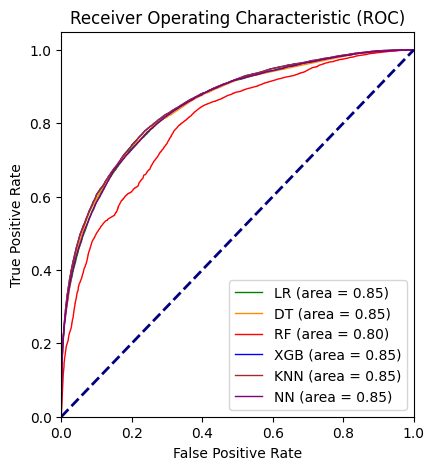

In [ ]:
fpr1, tpr1, _ = roc_curve(y_test, y_test_pred_proba_ns_lr)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_test_pred_proba_ns_dt)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_test_pred_proba_ns_rf)
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(y_test, y_test_pred_proba_ns_xgb)
roc_auc4 = auc(fpr4, tpr4)

fpr5, tpr5, _ = roc_curve(y_test, y_test_pred_proba_ns_kn)
roc_auc5 = auc(fpr5, tpr5)

fpr6, tpr6, _ = roc_curve(y_test, y_test_pred_proba_ns_nn)
roc_auc6 = auc(fpr6, tpr6)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr1, tpr1, color='green', lw=1, label=f'LR (area = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label=f'DT (area = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='red', lw=1, label=f'RF (area = {roc_auc3:.2f})')
plt.plot(fpr4, tpr4, color='blue', lw=1, label=f'XGB (area = {roc_auc4:.2f})')
plt.plot(fpr5, tpr5, color='brown', lw=1, label=f'KNN (area = {roc_auc5:.2f})')
plt.plot(fpr6, tpr6, color='purple', lw=1, label=f'NN (area = {roc_auc6:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

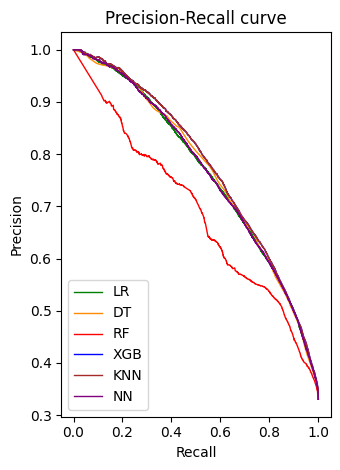

In [ ]:
# Precision-Recall curve
precision1, recall1, _ = precision_recall_curve(y_test, y_test_pred_proba_ns_lr)
precision2, recall2, _ = precision_recall_curve(y_test, y_test_pred_proba_ns_dt)
precision3, recall3, _ = precision_recall_curve(y_test, y_test_pred_proba_ns_rf)
precision4, recall4, _ = precision_recall_curve(y_test, y_test_pred_proba_ns_xgb)
precision5, recall5, _ = precision_recall_curve(y_test, y_test_pred_proba_ns_kn)
precision6, recall6, _ = precision_recall_curve(y_test, y_test_pred_proba_ns_nn)
plt.subplot(1, 2, 2)
plt.plot(recall1, precision1, color='green', lw=1, label='LR')
plt.plot(recall2, precision2, color='darkorange', lw=1, label='DT')
plt.plot(recall3, precision3, color='red', lw=1, label='RF')
plt.plot(recall4, precision4, color='blue', lw=1, label='XGB')
plt.plot(recall5, precision5, color='brown', lw=1, label='KNN')
plt.plot(recall6, precision6, color='purple', lw=1, label='NN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")      
plt.tight_layout()
plt.show()